In [1]:
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
from sod.jupyter.utils import * # our user defined functions
# Print a nice doc of the module functions just imported (`printdoc` is defined in `share`)
printdoc()

join,"Join two or more pathname components, inserting '/' as needed"
abspath,Return an absolute path.
dirname,Returns the directory component of a pathname
isfile,Test whether a path is a regular file
isdir,Return true if the pathname refers to an existing directory.
basename,Returns the final component of a pathname
splitext,Split the extension from a pathname
expanduser,Expand ~ and ~user constructions
isabs,Test whether a path is absolute
sys,This module provides access to some objects used or maintained by the
os,OS routines for NT or Posix depending on what system we're on


In [16]:
printhtml('<h3>Defining notebook variables</h3>')

# matplotlib stuff. Note that rcParams need to be input from the second cell on
# (https://github.com/jupyter/notebook/issues/3385#issuecomment-376010658)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# for font size details, see https://stackoverflow.com/a/39566040
plt.rcParams['figure.figsize'] = (7.08662, 7.08662)  # 18 cm
plt.rcParams['lines.linewidth'] = (7.08662, 7.08662)  # 18 cm
plt.rcParams['font.size'] = 15
plt.rcParams['axes.titlesize'] = plt.rcParams['font.size']
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = 'STFangsong,Trebuchet MS,cmss10,InaiMathi,STHeiti,Microsoft Sans Serif,Arial Narrow,Tahoma,Andale Mono,Yu Gothic Medium,AppleGothic,Tahoma,DejaVu Sans,GungSeo,helvetica,arial'
plt.rcParams['font.weight'] = 'normal'
# if set(plt.rcParams['font.family']) & set(['STFangsong',]):  # note: plt.rcParams['font.family'] has been converted to list
#     plt.rcParams['font.weight'] = 900  # 'bold'

# pandas settings. Some are set in `share`, display max_rows is explicitly set here
pd.set_option('display.max_rows', 25)

TRAINSET = 'allset_train.hdf'  # the first trainingset, without sod_dist
TRAINSET_U = 'uniform_train.hdf'  # the second trainingset, with sod_dist + uniform samples in (mag, dit) cells
TESTSETNAME1 = 'allset_test.hdf'  # the test of allset_train
TESTSETNAME2 = 'allset_unlabelled_annotation2.hdf'  # labelling by Bindi
TESTSETNAME_12 = 'allset_test_AND_allset_unlabelled_annotation2.hdf' # allset_test + labelling by Bindi
TESTSETNAME_UNLABELLED = 'allset_unlabelled.hdf'  # unlabelled stuff from allset_train and allset_test
TESTSETNAME_U = 'uniform_test.hdf'  # TESTNAME_12 + sod_dist

# columns to display for an Evaluation dataframe:
EVALDF_DISPLAYCOLUMNS = ['clf', 'feats', 'n_estimators', 'max_samples', 'random_state', 'average_precision_score',
                         'best_th_pr_curve', 'roc_auc_score', 'log_loss', 'relative_filepath',
                         # these are useless to show. The first is an experimental metric,
                         # the other three are parameters always equal for all models:
                         # 'best_th_roc_curve', 'behaviour', 'contamination',  'tr_set'
                        ]


from sod.core.paths import DATASETS_DIR


SAVE_FIGURES = True  # set to False to disable figures in the function below

def savefig(fig, name):
    '''Save a figure for the paper in a dedicated folder'''
    if not SAVE_FIGURES:
        print('(SAVE_FIGURES=False)')
        return
    root = os.path.expanduser('~')
    outpath = abspath(join(root, 'Nextcloud', 'rizac', 'outliers_paper', 'paper_figures'))
    assert isdir(outpath)
    outpath = join(outpath, name + '.png')
    # printhtml('Saving figure to "~/%s"' % os.path.relpath(abspath(outpath), root))
    printhtml(f'Saving figure to "~/{os.path.relpath(abspath(outpath), root)}" ')
    printhtml(f'(dpi: {plt.rcParams["figure.dpi"]} '
              f'size[w,h]: {plt.rcParams["figure.figsize"][0]:.2f} {plt.rcParams["figure.figsize"][1]:.2f})')
    fig.savefig(outpath, dpi=plt.rcParams['figure.dpi'], format='png')
    # join(dirname(dirname(dirname(os.getcwd())))

import yaml
from stream2segment.process.db import get_session, Segment, Station, Event, loads_inv, Base 

from obspy.signal.spectral_estimation import PPSD

def ppsd(raw_trace, inventory, periods=None):
    '''Returns the arrays
        periods, amplitudes_db
    Where amplitudes are the computed PSD (power spectral density)
    if the argument `periods` is not None but an array or scalar (in seconds), returns:
        periods, amplitudes_db_interpolated_on_periods
    '''
    try:
        # ppsd_ = psd(raw_trace, inventory)
        dt = raw_trace.stats.endtime - raw_trace.stats.starttime  # total_seconds
        ppsd_ = PPSD(raw_trace.stats, metadata=inventory, ppsd_length=int(dt))
        ppsd_.add(raw_trace)
    except Exception as esc:
        raise ValueError('%s error when computing PSD: %s' %
                         (esc.__class__.__name__, str(esc)))
    # check first if we can interpolate ESPECIALLY TO SUPPRESS A WEIRD
    # PRINTOUT (numpy?): something like '5064 5062' which happens
    # on IndexError (len(ppsd_.psd_values)=0)
    if not len(ppsd_.psd_values):
        raise ValueError('Expected 1 psd array, no psd computed')
    x, y = ppsd_.period_bin_centers, ppsd_.psd_values[0]
    if periods is None:
        return x, y
    periods = np.asarray(periods)
    newy = np.interp(np.log10(periods), np.log10(x), y)
    if np.ndim(newy) > 0:
        newy[periods < x[0]] = np.nan
        newy[periods > x[-1]] = np.nan
    return x, newy


@contextlib.contextmanager
def plotparams(params=None, figratio=1, hratio=1):
    '''makes temporarily matplotlib params.
    Make sure to run this after %matplotlib inline.
    For info see https://stackoverflow.com/questions/36367986/how-to-make-inline-plots-in-jupyter-notebook-larger'''
    params = params or {}
    def_params = {k: plt.rcParams[k] for k in params}
    wh = plt.rcParams['figure.figsize']
    def_params['figure.figsize'] = tuple(wh)
    if hratio is not None and hratio != 1:
        area, newh = wh[0] * wh[1], wh[1] * hratio
        params['figure.figsize'] = (area/newh, newh)
    if figratio is not None and figratio != 1:
        params['figure.figsize'] = (wh[0] * figratio, wh[1] * figratio)
    for k, v in params.items():
        plt.rcParams[k] = v
    try:
        yield
    finally:
        for k, v in def_params.items():
            plt.rcParams[k] = v

print('done')

Defining notebook variables

done


In [3]:
printhtml('<h3>Some stats on input datasets used</h3>')

for n in ['s2s_2019_03_at_rs5.hdf', 'me_at_rz_minus_vm258.hdf', 'sod_chile_at_rs5.hdf', 'sod_dist_2_20_at_rs5.hdf']:
    # store.close()
    store = pd.HDFStore(join(DATASETS_DIR, n))
    try:
        nrows = store.get_storer(list(store.keys())[0]).nrows
        printhtml(f'<h4>Dataset "{n}": {nrows:,d} segments</h4>')
        _ = pd.read_hdf(join(DATASETS_DIR, n), columns=['magnitude', 'distance_km'])
        display(pd.DataFrame(
            [
                [_['magnitude'].min(), _['magnitude'].median(), _['magnitude'].max()],
                [_['distance_km'].min(), _['distance_km'].median(), _['distance_km'].max()]
                
            ] ,
            index = ['Magnitude', 'Distance-km'],
            columns = ['Min', 'Median', 'Max']
        ))
        print()
    finally:
        store.close()
del _

Some stats on input datasets used

Opening /Users/riccardo/work/gfz/projects/sources/python/sod/sod/datasets/s2s_2019_03_at_rs5.hdf in read-only mode


Dataset "s2s_2019_03_at_rs5.hdf": 12,925,792 segments

,Min,Median,Max
Magnitude,0.000000,3.300000,6.900000
Distance-km,0.062138,225.387026,667.064639



Opening /Users/riccardo/work/gfz/projects/sources/python/sod/sod/datasets/me_at_rz_minus_vm258.hdf in read-only mode


Dataset "me_at_rz_minus_vm258.hdf": 7,037,596 segments

,Min,Median,Max
Magnitude,4.600000,5.800000,8.900000
Distance-km,2223.901682,8354.675457,10897.099856



Opening /Users/riccardo/work/gfz/projects/sources/python/sod/sod/datasets/sod_chile_at_rs5.hdf in read-only mode


Dataset "sod_chile_at_rs5.hdf": 159,300 segments

,Min,Median,Max
Magnitude,3.50000,4.200000,8.100000
Distance-km,0.99454,232.576006,10895.738036



Opening /Users/riccardo/work/gfz/projects/sources/python/sod/sod/datasets/sod_dist_2_20_at_rs5.hdf in read-only mode


Dataset "sod_dist_2_20_at_rs5.hdf": 36,972 segments

,Min,Median,Max
Magnitude,6.000000,6.30000,8.800000
Distance-km,222.582749,1420.69298,2223.878746


Some stats on training/testset used

allset_train.hdf : 1,892,367 segments. Detailed segments distributions:

old training set, printed here just for reference

Dataset         All                 1                 2                 3  \
Window       signal    noise   signal    noise   signal    noise   signal   
inliers   1,018,971  873,396  300,377  300,375  573,021  573,021  145,573   
outliers          0        0        0        0        0        0        0   
Total     1,018,971  873,396  300,377  300,375  573,021  573,021  145,573   

Dataset         
Window   noise  
inliers      0  
outliers     0  
Total        0

uniform_train.hdf : 405,835 segments. Detailed segments distributions:

Dataset       All                1                2               3        \
Window     signal    noise  signal   noise   signal   noise  signal noise   
inliers   272,760  133,075  24,315  45,111  220,002  85,948  18,675     0   
outliers        0        0       0       0        0       0       0     0   
Total     272,760  133,075  24,315  45,111  220,002  85,948  18,675     0   

Dataset       4         
Window   signal  noise  
inliers   9,768  2,016  
outliers      0      0  
Total     9,768  2,016

uniform_test.hdf : 852,287 segments. Detailed segments distributions:

Dataset       All                 1                 2                3        \
Window     signal    noise   signal    noise   signal    noise  signal noise   
inliers   264,022  250,647  156,759  156,762   92,847   92,847  13,727     0   
outliers  168,813  168,805   44,548   44,543  124,069  124,062       0     0   
Total     432,835  419,452  201,307  201,305  216,916  216,909  13,727     0   

Dataset       4         
Window   signal  noise  
inliers     689  1,038  
outliers    196    200  
Total       885  1,238

Plotting mag/dist segments distribution (inliers only, signal only)

min/max segments per cell: 0, 122589


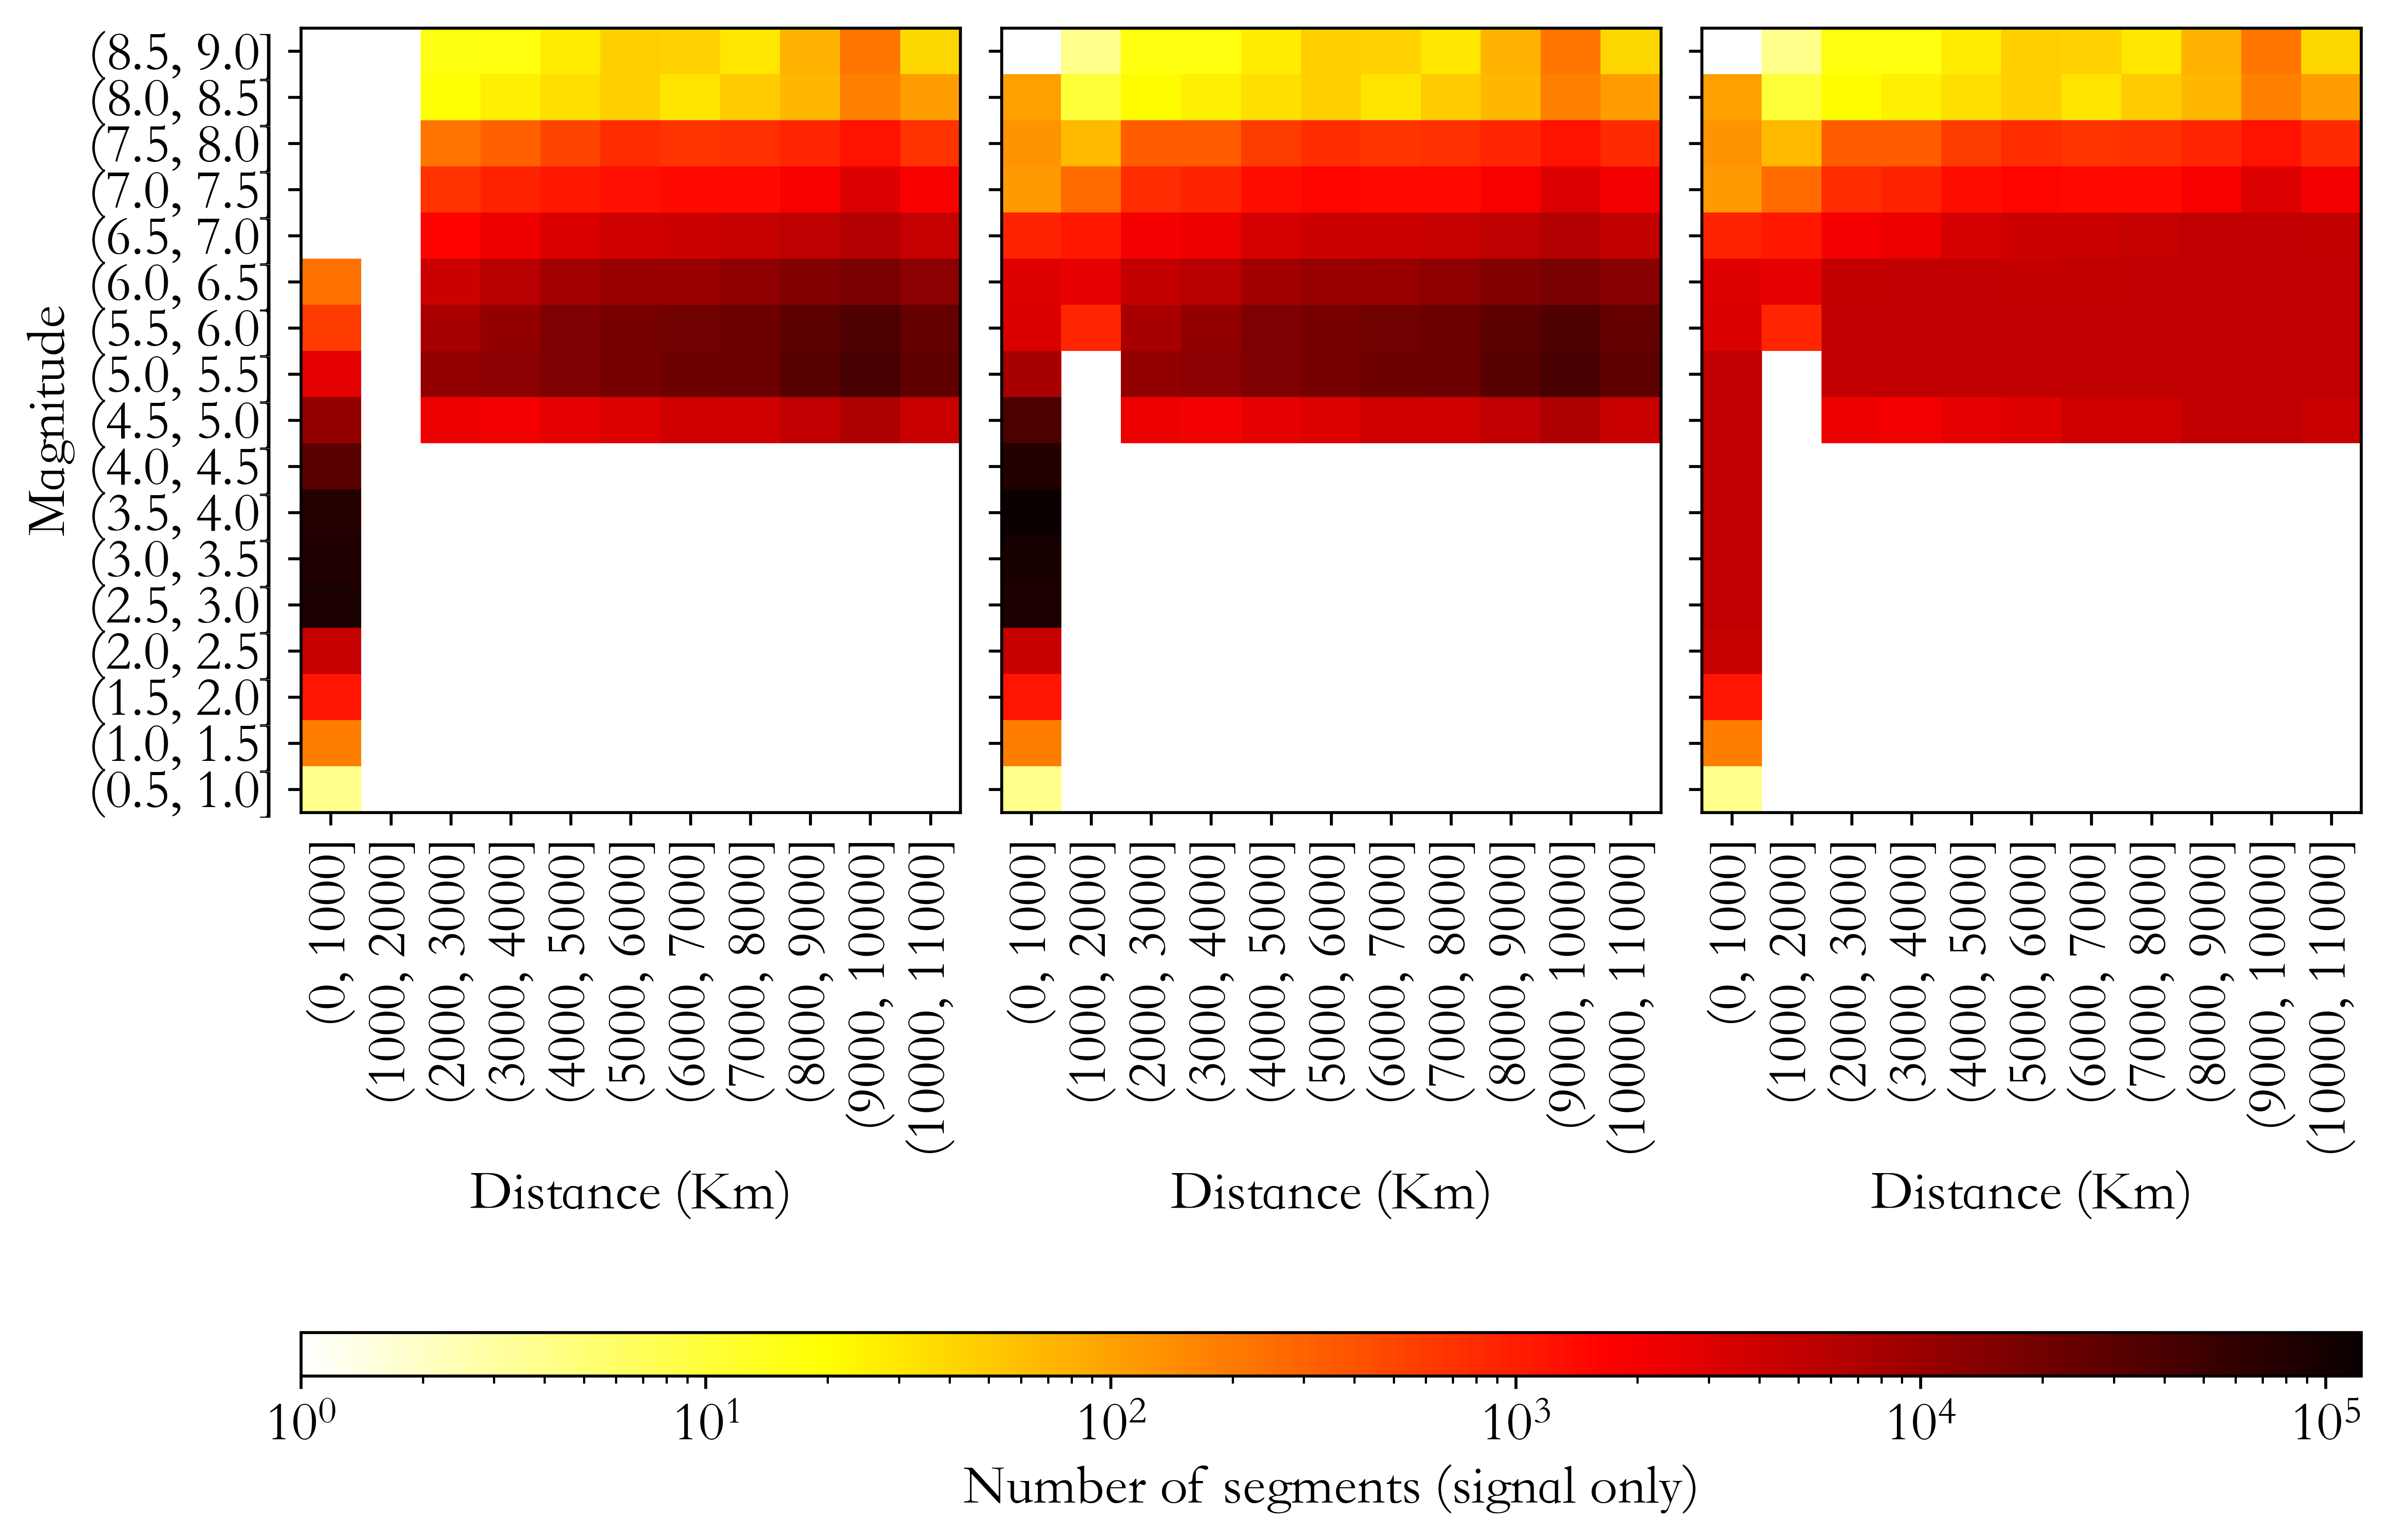

Saving figure to "~/Nextcloud/rizac/outliers_paper/paper_figures/segments_magdistance_distribution.png"

(dpi: 300.0 size[w,h]: 8.86 5.67)

In [4]:
# fonts = ['Helvetica', 'Microsoft Sans Serif', 'Arial Narrow']
# plt.rcParams['font.family'] = 'Tahoma,Microsoft Sans Serif,Arial Narrow'  # ,Yu Gothic Medium,AppleGothic,Tahoma,DejaVu Sans,helvetica,arial'

printhtml(f'<h3>Some stats on training/testset used</h3>')

setnames = [TRAINSET, TRAINSET_U, TESTSETNAME_U]
heatmap_dfs = []  # store our dataframes of signals only here for the heatmap (we will plot it later)
heatmap_xname, heatmap_yname = 'distance_km', 'magnitude'
heatmap_xrange, hetmap_yrange = np.arange(0, 12000, 1000), np.arange(0.5, 9.5, 0.5)


for i, setname in enumerate(setnames):
    # plt.rcParams['font.family'] = fonts[i]
    _ = pd.read_hdf(join(DATASETS_DIR, setname), columns=['magnitude', 'dataset_id',
                                                          'distance_km', 'window_type', 'outlier'])
    printhtml(f'<h4><b>{setname}</b>: {len(_):,} segments. Detailed segments distributions:</h4>')
    if setname == TRAINSET:
        printhtml('<h4>old training set, printed here just for reference</h4>')
    w, o = _.window_type, _.outlier
    inl_row = []  # [len(_[w & (~o)]), len(_[(~w) & (~o)])]
    outl_row = []  # [len(_[w & o]), len(_[(~w) & o])]
    columns = []
    for did in [None] + sorted(pd.unique(_.dataset_id)):
        capt = 'All' if did is None else '%d' % did
        columns.extend([ (capt, 'signal'), (capt, 'noise') ])
        __ = _ if did is None else _[_.dataset_id == did]
        w, o = __.window_type, __.outlier
        inl_row.extend([len(__[w & (~o)]), len(__[(~w) & (~o)])])
        outl_row.extend([len(__[w & o]), len(__[(~w) & o])])
    _sum = pd.DataFrame([
        inl_row,  # 1st row
        outl_row,         # 2nd row 
        ],
        index = ['inliers', 'outliers'],
        columns=columns,
    )
    _sum.columns = pd.MultiIndex.from_tuples(_sum.columns, names=['Dataset','Window'])
    _sum = _sum.append(_sum.sum(axis=0).rename('Total'))
    # _sum['Total'] = _sum.sum(axis=1)
    for c in _sum.columns:
        _sum[c] = _sum[c].apply(lambda x : "{:,}".format(x))
    display(_sum)
    heatmap_dfs.append(_[_.window_type & (~_.outlier)])

    
print()
printhtml(f'<h4>Plotting mag/dist segments distribution (inliers only, signal only)</h4>')


# re arrange the (yet-to-be) heatmaps:
heatmap_dfs[2] = heatmap_dfs[1]
heatmap_dfs[1] = pd.concat([heatmap_dfs[0], heatmap_dfs[1][heatmap_dfs[1].dataset_id == 4]], axis=0, ignore_index=True)
heatmap_dfs[0] = heatmap_dfs[0][heatmap_dfs[0].dataset_id <= 2]
# and now build the real heatmaps:
heatmap_dfs = [heatmap_df(_, heatmap_xname, heatmap_yname, heatmap_xrange, hetmap_yrange)
              for _ in heatmap_dfs]
    
# plot heatmaps:
min_, max_ = np.inf, -np.inf
for hmap_df in heatmap_dfs:
    if hmap_df.min().min() < min_:
        min_ = hmap_df.min().min()
    if hmap_df.max().max() > max_:
        max_ = hmap_df.max().max()

print(f'min/max segments per cell: {min_}, {max_}')

cmap='hot_r'
norm = matplotlib.colors.LogNorm(vmin=1, vmax=max_, clip=True)  # max_, clip=True)


with plotparams(hratio=0.8):

    fig = plt.figure(constrained_layout=True)
    gsp = fig.add_gridspec(3, len(setnames), height_ratios=[.9, .05, .05])

    for i, hmap_df in enumerate(heatmap_dfs):

        axs = fig.add_subplot(gsp[0, i])
        axs.pcolor(hmap_df, cmap=cmap, norm=norm)  # cmap='cubehelix_r')  #

        axs.set_yticks(np.arange(0.5, len(hmap_df.index), 1))
        if i == 0:
            axs.set_yticklabels(hmap_df.index)
            axs.set_ylabel(heatmap_yname.title().replace('_', ' '))
        else:
            axs.set_yticklabels([])
        axs.set_xticks(np.arange(0.5, len(hmap_df.columns), 1))
        axs.set_xticklabels(hmap_df.columns)
        axs.set_xlabel(heatmap_xname.title().replace('_', ' (') + ')')
        axs.xaxis.set_tick_params(rotation=90)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    axs = fig.add_subplot(gsp[2, :])
    cbar = plt.colorbar(sm, cax=axs, orientation='horizontal')  # , pad=1, shrink=0.5, use_gridspec=True)  #, ticks=np.linspace(0,2,N), )
    cbar.ax.set_xlabel('Number of segments (signal only)')
    plt.show()

    savefig(fig, 'segments_magdistance_distribution')

# samey(_)
# plt.rcParams['figure.figsize'] = (10, 10)
del _
del hmap_df
del heatmap_dfs
# savefig(fig, 'tsets_segments_freqdist')
# plt.show()    

In [5]:
printhtml('<h3>Loading evaluation dataframe</h3>')
eval_df = read_eval_df('evaluationmetrics.hdf') #  read_summary_eval_df()

for setname in [TESTSETNAME_U, TESTSETNAME_12]:
    print()
    printhtml('<h4>Testset: "%s". Best models under "average precision score" (APS)</h4>' % setname)
    display(eval_df[eval_df.relative_filepath.str.endswith(os.sep + setname)].
            sort_values(['average_precision_score'], ascending=False)[EVALDF_DISPLAYCOLUMNS])

Loading evaluation dataframe

Testset: "uniform_test.hdf". Best models under "average precision score" (APS)

,clf,feats,n_estimators,max_samples,random_state,average_precision_score,best_th_pr_curve,roc_auc_score,log_loss,relative_filepath
1607,IsolationForest,psd@5sec,50,512,25,0.971079,0.730038,0.976689,0.590869,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=50&random_state=25/uniform_test.hdf
1605,IsolationForest,psd@5sec,100,512,25,0.970786,0.741438,0.976366,0.597247,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=25/uniform_test.hdf
1594,IsolationForest,psd@5sec,100,1024,25,0.970586,0.752108,0.975150,0.581386,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=25/uniform_test.hdf
1592,IsolationForest,psd@5sec,100,1024,11,0.970564,0.739007,0.975348,0.577372,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/uniform_test.hdf
1104,IsolationForest,psd@5sec,100,1024,42,0.970494,0.745727,0.975156,0.574587,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=42/uniform_test.hdf
1604,IsolationForest,psd@5sec,100,512,11,0.970490,0.743559,0.975866,0.604658,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=11/uniform_test.hdf
1105,IsolationForest,psd@5sec,50,1024,42,0.970405,0.737435,0.975189,0.579604,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=50&random_state=42/uniform_test.hdf
1598,IsolationForest,psd@5sec,50,2048,25,0.970360,0.716539,0.974505,0.560193,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50&random_state=25/uniform_test.hdf
1597,IsolationForest,psd@5sec,100,2048,25,0.970295,0.714902,0.974611,0.563666,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=25/uniform_test.hdf
1599,IsolationForest,psd@5sec,50,2048,11,0.970213,0.737760,0.975100,0.559445,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50&random_state=11/uniform_test.hdf


Testset: "allset_test_AND_allset_unlabelled_annotation2.hdf". Best models under "average precision score" (APS)

,clf,feats,n_estimators,max_samples,random_state,average_precision_score,best_th_pr_curve,roc_auc_score,log_loss,relative_filepath
830,IsolationForest,psd@5sec,100,2048,42,0.970866,0.746330,0.974132,0.606184,clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=42/allset_test_AND_allset_unlabelled_annotation2.hdf
842,IsolationForest,psd@5sec,200,4096,25,0.970687,0.718142,0.974026,0.588646,clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=200&random_state=25/allset_test_AND_allset_unlabelled_annotation2.hdf
843,IsolationForest,psd@5sec,50,4096,11,0.970605,0.726551,0.974377,0.587202,clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=50&random_state=11/allset_test_AND_allset_unlabelled_annotation2.hdf
833,IsolationForest,psd@5sec,200,2048,42,0.970577,0.746689,0.974144,0.607408,clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=200&random_state=42/allset_test_AND_allset_unlabelled_annotation2.hdf
841,IsolationForest,psd@5sec,200,4096,42,0.970573,0.715107,0.973585,0.587802,clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=200&random_state=42/allset_test_AND_allset_unlabelled_annotation2.hdf
840,IsolationForest,psd@5sec,200,4096,11,0.970509,0.718866,0.973985,0.590698,clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=200&random_state=11/allset_test_AND_allset_unlabelled_annotation2.hdf
828,IsolationForest,psd@5sec,100,2048,11,0.970464,0.756818,0.974035,0.610812,clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/allset_test_AND_allset_unlabelled_annotation2.hdf
831,IsolationForest,psd@5sec,200,2048,11,0.970408,0.746150,0.973771,0.610380,clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=200&random_state=11/allset_test_AND_allset_unlabelled_annotation2.hdf
858,IsolationForest,psd@5sec,200,8192,11,0.970393,0.688365,0.973803,0.579433,clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=200&random_state=11/allset_test_AND_allset_unlabelled_annotation2.hdf
834,IsolationForest,psd@5sec,50,2048,11,0.970364,0.757912,0.973979,0.614826,clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50&random_state=11/allset_test_AND_allset_unlabelled_annotation2.hdf


Saving figure to "~/Nextcloud/rizac/outliers_paper/paper_figures/testset_uniform.png"

(dpi: 300.0 size[w,h]: 7.09 7.09)

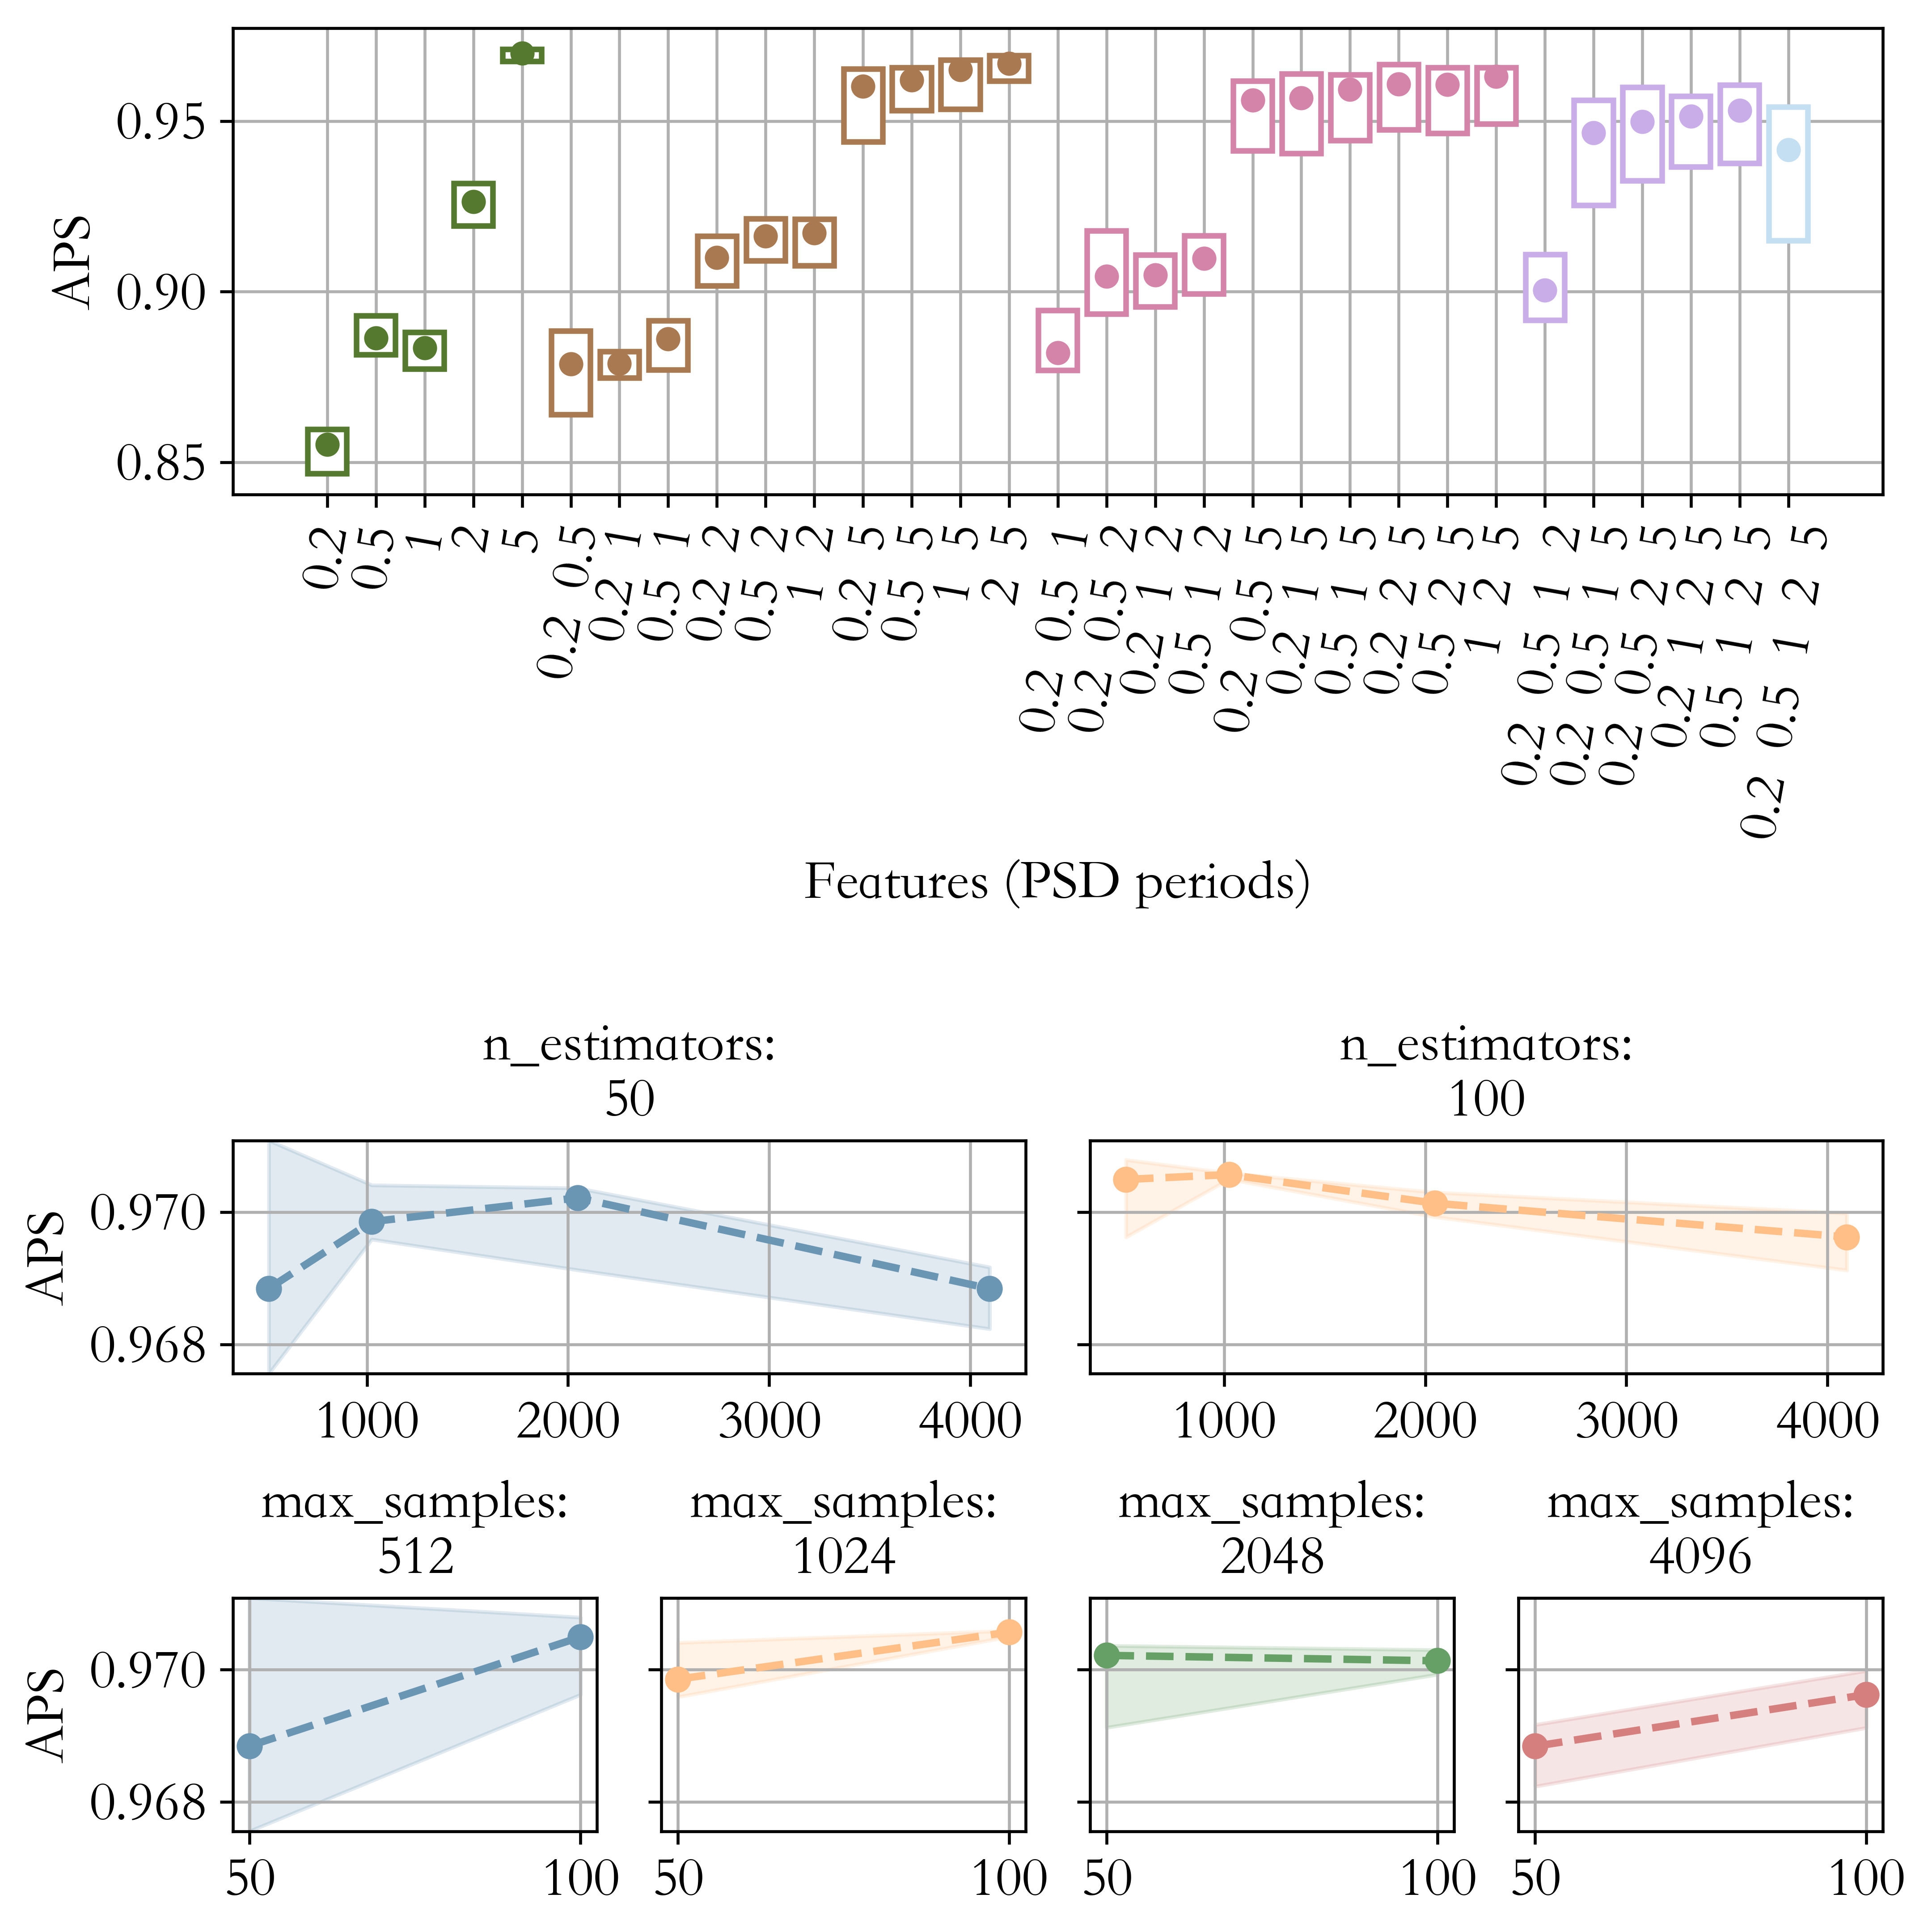

In [6]:
# sets = [(TESTSETNAME1, 'feats_and_hp_testset1'), (TESTSETNAME2, 'feats_and_hp_testset2')]
sets = [(TESTSETNAME_U, 'testset_uniform')]  #, (TESTSETNAME2, 'feats_and_hp_testset2')]

SCORE = 'average_precision_score'
score_label = 'APS'
# ne, ms = [50, 100, 200], [512, 1024, 2048, 4096, 8192, 16384]
ne, ms = [50, 100], [512, 1024, 2048, 4096]


for setname, filename in sets:
    print()
    fig = plt.figure(constrained_layout=True)
    gsp = fig.add_gridspec(4, max(len(ne), len(ms)), height_ratios=[10, 1, 5, 5])
    eval_df_ = eval_df[eval_df.relative_filepath.str.endswith(os.sep + setname)]
    axs = fig.add_subplot(gsp[0, :])
    plot_feats_vs_evalmetrics(eval_df_, [SCORE], ylabel=lambda metric: score_label, show=[axs])

    eval_df_ = eval_df_[eval_df_.feats.str.match('psd@5sec')]  # eval_df_[eval_df_.feats.str.contains('psd@5sec')]
    # eval_df_ = eval_df_[eval_df_.feats == 'psd@5sec']
    dfmin, dfmedian, dfmax = get_hyperparam_dfs(eval_df_, SCORE, n_estimators=ne, max_samples=ms)


    axs = [fig.add_subplot(gsp[2, 2*i: 2*i+2]) for i in range(len(ne))]
    plot_hyperparam_dfs(dfmin, dfmedian, dfmax, ylabel=score_label, show=axs)

    axs = [fig.add_subplot(gsp[3, i]) for i in range(len(ms))]
    plot_hyperparam_dfs(dfmin.T, dfmedian.T, dfmax.T, ylabel=score_label, show=axs)

    savefig(fig, filename)

Analyzing HP and time complexity (aka time performance) for psd@5sec

Getting a random segment and computing the time required for converting to PSD

/Users/riccardo/work/gfz/projects/sources/python/sod/.env/sod/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


Trace length: 0:04:00.606000


Time required to convert ONE stream of 240.606000 seconds into a single scalar PSD@5s: 0.08688902854919434

With 100,000 instances it would mean aproximately (H:m:s.msec): 2:24:48.902855

Plotting Time performances

(Performances on 100,000 PSD periods computed at 5 seconds)

[●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●] 100.0% 0:00:00

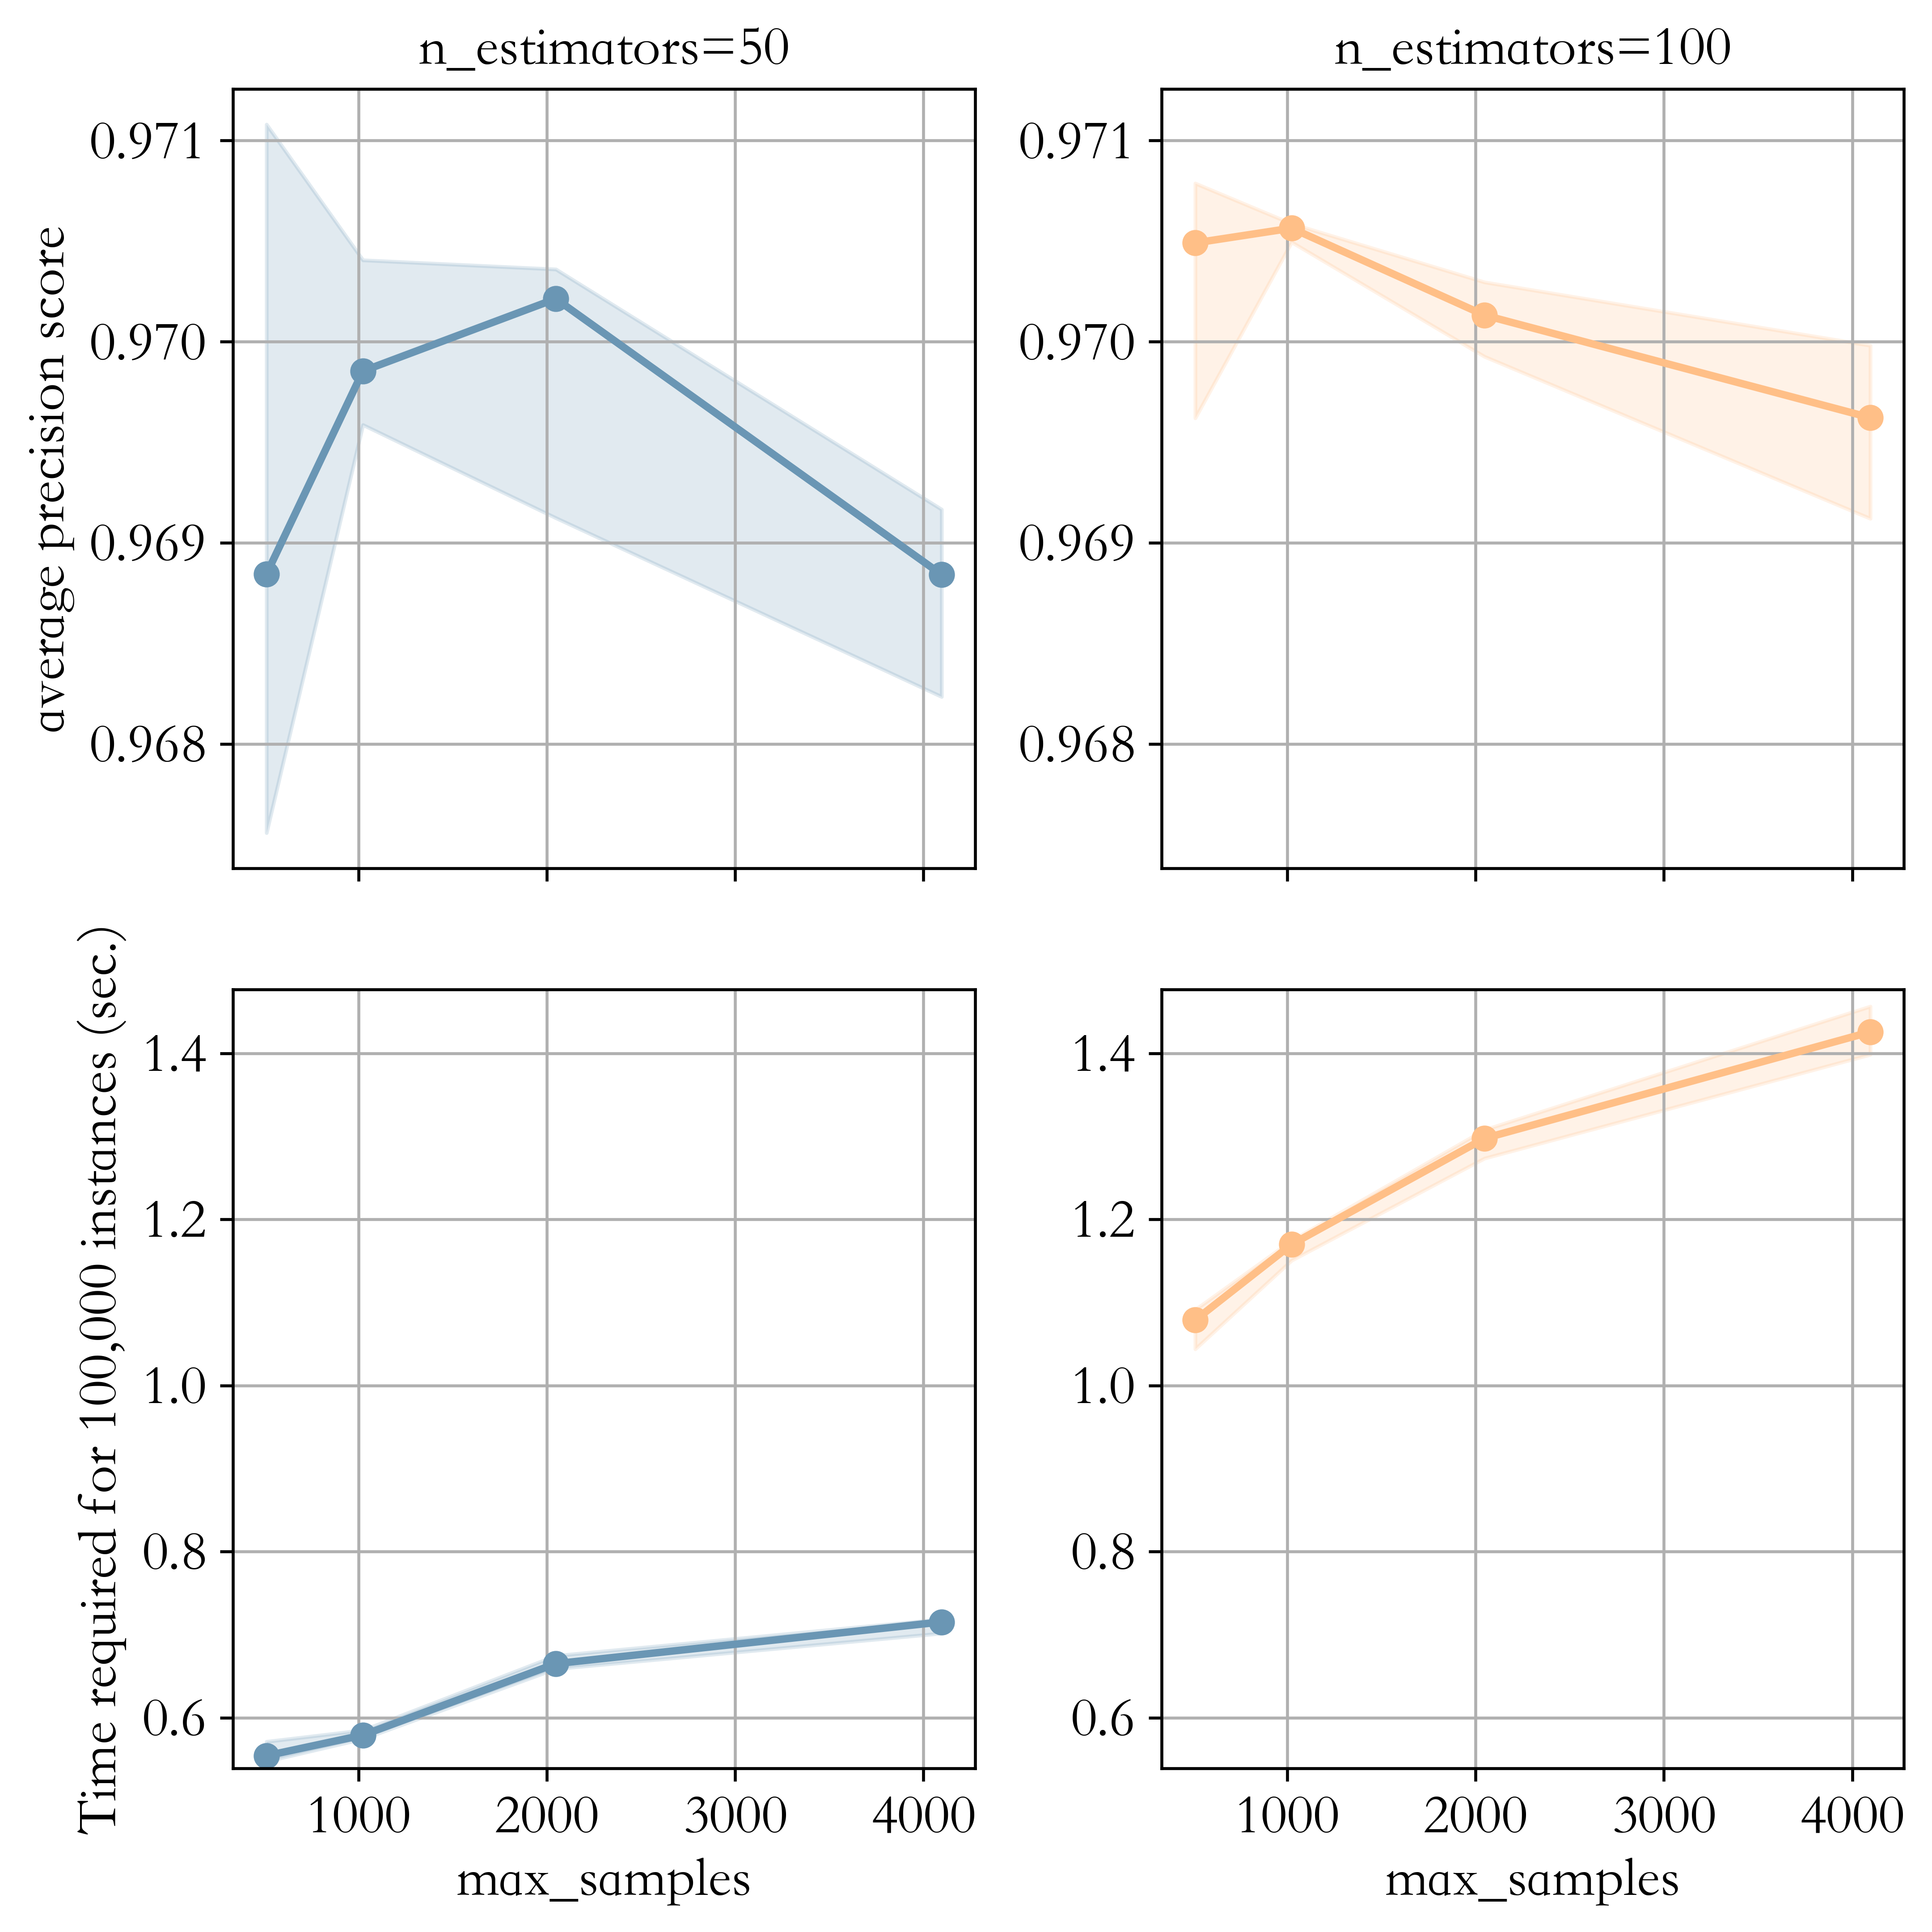

In [7]:
printhtml('<h3>Analyzing HP and time complexity (aka time performance) for psd@5sec</h3>')

printhtml('<h3>Getting a random segment and computing the time required for converting to PSD</h3>')


with dbsession(1) as sess:
    # this is TOO COSTLY: 
    #  data = sess.query(Segment.data, Station.inventory_xml).join(Segment.station).\
    #      filter(Segment.has_data).order_by(Segment.data.desc()).limit(1).first()

    # I EXECUTED THE QUERY ON THE WEB PAGE:
    #
    # select segments.id, length(segments.data) from segments where segments.data is not null and segments.maxgap_numsamples < 0.5 and segments.maxgap_numsamples > -0.5 order by length(segments.data) desc limit 5
    #
    # AND GOT THESE IDS (with data length sorted descending, first 5 results):
    # 2590524 2392064
    # 2581456 2387968
    # 2592296 2387968
    # 2598859 2387968
    # 2597781 2387968
    # so:
    data = sess.query(Segment.data, Station.inventory_xml).join(Segment.station).\
                  filter(Segment.id == 2590524).one()

# read trace:
from obspy import read, read_inventory
from io import BytesIO
stream = read(BytesIO(data[0]))
inv_xml = loads_inv(data[1])
raw_trace = sorted(stream, key=lambda _ : _.stats.endtime - _.stats.starttime, reverse=True)[0]
print('Trace length: %s' % str(timedelta(seconds=raw_trace.stats.endtime - raw_trace.stats.starttime)) )


# defining the functions for converting to specturm (as used in the stream2segment config, these
# might be optimized)

N_PERIODS = 100000

# estimate the time required for computing the PSD @ 5 seconds
t = time.time()
ppsd(raw_trace, inv_xml, 5)
t = time.time() - t
printhtml('<h4> Time required to convert ONE stream of %f seconds into a single scalar PSD@5s: %s</h4>' %
         (raw_trace.stats.endtime - raw_trace.stats.starttime, t))
printhtml(f'<h4> With {N_PERIODS:,} instances it would mean aproximately (H:m:s.msec): %s' %
         str(timedelta(seconds=N_PERIODS*t)))


printhtml('<h3>Plotting Time performances</h3>')
printhtml(f'(Performances on {N_PERIODS:,} PSD periods computed at 5 seconds)')

# let's see how much different models with different random state have differences are actually
# psdvals = np.arange(-250, 0, .1)
psdvals = np.linspace(-250, 0, N_PERIODS, endpoint=True)
psdvals_ = psdvals.reshape(len(psdvals), 1)

# defining constansts like variables
maxs = [512, 1024, 2048, 4096]  #  np.unique(eval_df.max_samples.values)
nest = [50, 100]  # np.unique(eval_df.n_estimators.values)
setname = TESTSETNAME_U # TESTSETNAME_12


fig = plt.figure(constrained_layout=True)
gsp = fig.add_gridspec(2, len(nest))

axss = [[], []]
colors = get_colors(len(nest))
_baralign = -500

pbar = progressbar(len(maxs) * len(nest))
with plotparams(hratio=0.8):
    for idx_, (ne, c) in enumerate(zip(nest, colors)):
        eval_df_ = eval_df[(eval_df.feats == 'psd@5sec')  & (eval_df.n_estimators == ne) &
                           # this end is only needed to restrict the models to a single test set, otherwise
                           # we compute the same model more than once which does not make much sense.
                           # Also, we want to report the APSs so we choose to report those of the
                           # two models combined:
                           (eval_df.relative_filepath.str.endswith(os.sep + setname))]
        mintimes = []
        maxtimes = []
        mediantimes = []
        minaps = []
        maxaps = []
        medianaps = []
        apss = []
        for ms in maxs:
            pbar.update(1)
            # display('Processing n_estimators=%d, max_samples=%d' % (ne, ms))
            times = []
            aps_ = []
            for rowtuple in eval_df_[eval_df_.max_samples == ms].itertuples(index=False):
                clf = load_clf(dirname(rowtuple.relative_filepath) + '.sklmodel')
                t = time.time()
                current_scores = -clf.score_samples(psdvals_)
                t = time.time() - t
                times.append(t)
                aps_.append(rowtuple.average_precision_score)
            mintimes.append(np.nanmin(times))
            mediantimes.append(np.nanmedian(times))
            maxtimes.append(np.nanmax(times))
            minaps.append(np.nanmin(aps_))
            medianaps.append(np.nanmedian(aps_))
            maxaps.append(np.nanmax(aps_))

        title = 'n_estimators=%d' % ne

        axs = fig.add_subplot(gsp[0, idx_])
        axs.plot(maxs, medianaps, linewidth=2, marker='o', color=c, label='n_estimators=%d' % ne)
        axs.fill_between(maxs, minaps, maxaps, alpha=0.2, color=c)
        axs.grid()
        axs.set_title(title)
        axs.set_xticklabels([])
        if idx_ == 0:
            axs.set_ylabel('average precision score')
        axss[0].append(axs)

        axs = fig.add_subplot(gsp[1, idx_])
        axs.plot(maxs, mediantimes, linewidth=2, marker='o', color=c, label=title)
        axs.fill_between(maxs, mintimes, maxtimes, alpha=0.2, color=c)
        axs.grid()
        if idx_ == 0:
            axs.set_ylabel(f'Time required for {N_PERIODS:,} instances (sec.)')
        axs.set_xlabel('max_samples')
        axss[1].append(axs)

    for _ in axss:
        samex(_)
        samey(_)

    # UNCOMMENT HERE BELOW IF YOU WANT TO SAVE THE FIGURE:
    # filename = 'feat5sec_hp_and_time_perf_bothsets'
    # savefig(fig, filename)
    plt.show()

In [15]:
setname = TESTSETNAME_U

printhtml('<h3>Plotting best models in details. All metrics computed on test set "%s"</h3>' % setname)


printhtml('<h4>Grouping models by (n_estimators, max_samples) and keeping those with median '
          'average precision score</h3>')

eval_df2 = []
for _, _df in eval_df[(eval_df.feats == 'psd@5sec') &
                      (eval_df.relative_filepath.str.endswith(os.sep + setname))].\
        groupby(['n_estimators', 'max_samples']):
    _df = _df[_df.average_precision_score == _df.average_precision_score.median()]
    # _df = _df[_df.random_state == 11]
    assert len(_df) == 1
    eval_df2.append(_df)
    # eval_df2.append(_df.sort_values('average_precision_score')[1:2])  # median
eval_df2 = pd.concat(eval_df2, axis=0, sort=False)

pd.set_option('display.max_rows', 500)
# display(eval_df.sort_values(['average_precision_score'], ascending=False).head(30))
display(eval_df2.sort_values(['average_precision_score'], ascending=False)[EVALDF_DISPLAYCOLUMNS])



printhtml('<h4>Defining plot function and plotting</h4>')

def plot_prediction_per_maxsamples(pred_dfs):
    
    from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                                   AutoMinorLocator)

    # printhtml('<h3>Summary plots n_estimators=200 only (and random_state=11)</h3>')

    PETTERSON_PERIOD = 5  # set to 0 to ignore

    rows, cols = len(pred_dfs), 4
    # rows, cols = 2*len(pred_dfs), 3
    fig = plt.figure(constrained_layout=True)
    gsp = fig.add_gridspec(rows, cols, width_ratios=[1,10, 10, 10])
    # gsp = fig.add_gridspec(rows, cols, height_ratios=[1,15] * len(pred_dfs))
    colors = get_colors(len(pd.unique([_.max_samples for _ in pred_dfs.keys()])))
    psdperiods = np.arange(-230, 0, 0.1)

    # axs_all = [[], [], []]
    for idx, (rowtuple, pred_df) in enumerate(pred_dfs.items()):
        title= "(max_s=%s)" % (rowtuple.max_samples)

        aps, p, r, th, f = EVALMETRICS.computeall(pred_df, EVALMETRICS.APS,
                                                  EVALMETRICS.PMAX, EVALMETRICS.RMAX,
                                                  EVALMETRICS.BEST_TH_PR, EVALMETRICS.F1MAX)

        axs = fig.add_subplot(gsp[idx, 1])
        mp_hist_kw = {
            'color': ['white', colors[idx]],
            'edgecolor':colors[idx],
            'histtype': 'stepfilled', 'stacked': True,
            'linewidth': 2
        }
        axs = plot_freq_distribution(pred_df, axs, title='', mp_hist_kwargs=mp_hist_kw)
        axs.set_xticks([0.5, np.round(th, 2)])
        axs.tick_params(which='major', length=7)
        axs.set_axisbelow(True)

        axs = fig.add_subplot(gsp[idx, 2])
        axs = plot_pre_rec_fscore(pred_df, axs, title='', mp_plot_kwargs={'color': colors[idx]})
        axs.tick_params(which='major', length=7)
        # bbox_to_anchor: A 2-tuple (x, y) places the corner of the legend specified by `loc` at x, y. 
        lgnd = axs.legend(loc='lower center', bbox_to_anchor=(0.5, 0))
        axs.set_ylim(-0.2, 1.02)
        axs.set_axisbelow(True)

        axs = fig.add_subplot(gsp[idx, 3])
        clf = load_clf(dirname(rowtuple.relative_filepath) + '.sklmodel')
        scores = -clf.score_samples(psdperiods.reshape(len(psdperiods), 1))
        # plot scores:
        axs.plot(psdperiods, scores, color=colors[idx], linewidth=2)
        # plot petterson:
        pbounds = get_petterson_bounds(PETTERSON_PERIOD)
        axs.axvline(pbounds[0], linestyle=':', linewidth=2)
        axs.axvline(pbounds[1], linestyle=':', linewidth=2)
        # plot shaded areas between 0.5 and score optimizing f1score:
        indices1 = argwhere_array_equals_value(scores, th)
        indices2 = argwhere_array_equals_value(scores, 0.5)
        psd_l = psdperiods[indices1[0]], psdperiods[indices2[0]]
        axs.axvspan(psd_l[0], psd_l[1], alpha=0.2, linestyle='--', linewidth=0, color=colors[idx])
        psd_h = psdperiods[indices2[-1]], psdperiods[indices1[-1]]
        axs.axvspan(psd_h[0], psd_h[1], alpha=0.2, linestyle='--', linewidth=0, color=colors[idx])
        axs.grid()
        # displaying bounds:
        bound1 = str([int(psd_l[0]+0.5), int(psd_l[1]+0.5)])
        bound2 = str([int(psd_h[0]+0.5), int(psd_h[1]+0.5)])
        w1 = float(psd_l[1] - psd_l[0])
        w2 = float(psd_h[1] - psd_h[0])
        axs.text(psd_l[1] - w1/2.0, min(scores), bound1, ha='right', va='bottom', backgroundcolor=[1,1,1,0.5])
        axs.text(psd_h[0] + w2/2.0, min(scores), bound2, ha='left', va='bottom', backgroundcolor=[1,1,1,0.5])
        # set axis ticks:
        axs.xaxis.set_minor_locator(MultipleLocator(25))
        axs.yaxis.set_minor_locator(MultipleLocator(0.1))
        axs.grid(axis="both", which='minor', linestyle='-')
        axs.set_yticks([0.5, np.round(th, 2)])
        axs.tick_params(which='major', length=7)
        axs.set_xlabel('psd(5) (dB)')
        axs.set_ylabel('score')
        axs.set_axisbelow(True)
        
        # summary in the leftmost plot:
        # plot it as last so we have all data avilable
        axs = fig.add_subplot(gsp[idx, 0])
        text = f'$\psi$: {rowtuple.max_samples:>5d}\nAPS: {aps:.3f}' # % (rowtuple.max_samples, aps)
        axs.text(0.5, 1, text, ha='right', va='top', rotation=0, linespacing=2)  # , family='monospace') 
        axs.set_axis_off()

    return fig


with plotparams(figratio=1.2):  #  {'font.size': 12}, hratio=.9):  # {'figure.figsize'] = (14, 16), plt.rcParams['font.size'] = 14
    for nest in [100]:  # [50, 100, 200]:
        print()
        printhtml('<h4>Plotting detailed model predictions with n_estimators=%d</h4>' % nest)
        pred_dfs = get_pred_dfs(eval_df2[eval_df2.n_estimators == nest], columns=['predicted_anomaly_score', 'window_type', 'outlier', 'dataset_id'])
        # for _ in list(pred_dfs):
        #    pred_dfs[_] = pred_dfs[_][(pred_dfs[_].dataset_id==1) & ((pred_dfs[_].window_type))]
        fig = plot_prediction_per_maxsamples(pred_dfs)
        savefig(fig, 'feat5sec_allperfs_nest=%d' % nest)
        plt.show()

Plotting best models in details. All metrics computed on test set "uniform_test.hdf"

Grouping models by (n_estimators, max_samples) and keeping those with median average precision score

,clf,feats,n_estimators,max_samples,random_state,average_precision_score,best_th_pr_curve,roc_auc_score,log_loss,relative_filepath
1592,IsolationForest,psd@5sec,100,1024,11,0.970564,0.739007,0.975348,0.577372,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/uniform_test.hdf
1604,IsolationForest,psd@5sec,100,512,11,0.970490,0.743559,0.975866,0.604658,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=11/uniform_test.hdf
1599,IsolationForest,psd@5sec,50,2048,11,0.970213,0.737760,0.975100,0.559445,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50&random_state=11/uniform_test.hdf
1596,IsolationForest,psd@5sec,100,2048,11,0.970131,0.723908,0.974888,0.559709,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/uniform_test.hdf
1595,IsolationForest,psd@5sec,50,1024,25,0.969853,0.739561,0.975201,0.574039,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=50&random_state=25/uniform_test.hdf
1602,IsolationForest,psd@5sec,100,4096,25,0.969622,0.680671,0.974166,0.556366,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=100&random_state=25/uniform_test.hdf
1606,IsolationForest,psd@5sec,50,512,11,0.968845,0.745870,0.975527,0.605512,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=50&random_state=11/uniform_test.hdf
1601,IsolationForest,psd@5sec,50,4096,11,0.968842,0.668166,0.973910,0.556683,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=50&random_state=11/uniform_test.hdf


Defining plot function and plotting

TypeError: plotparams() got an unexpected keyword argument 'figratio'

In [9]:
setname = TESTSETNAME_U
n_est = 100

# printhtml('<h3>Performances per dataset. All metrics computed on test set "%s"</h3>' % setname)


# printhtml('<h4>Grouping models by (n_estimators, max_samples) and keeping those with median '
#           'average precision score</h3>')

eval_df2 = []
for _, _df in eval_df[(eval_df.feats == 'psd@5sec') & (eval_df.n_estimators == n_est) &
                      (eval_df.relative_filepath.str.endswith(os.sep + setname))].\
        groupby(['n_estimators', 'max_samples']):
    _df = _df[_df.average_precision_score == _df.average_precision_score.median()]
    # _df = _df[_df.random_state == 11]
    assert len(_df) == 1
    eval_df2.append(_df)
    # eval_df2.append(_df.sort_values('average_precision_score')[1:2])  # median
eval_df2 = pd.concat(eval_df2, axis=0, sort=False)

pd.set_option('display.max_rows', 500)
# display(eval_df.sort_values(['average_precision_score'], ascending=False).head(30))

printhtml(f'Performances on "{setname}" (same as previous Notebook cell but restricted to n_estimators={n_est})"')
display(eval_df2.sort_values(['average_precision_score'], ascending=False)[EVALDF_DISPLAYCOLUMNS])

printhtml(f'Loading {len(eval_df2)} prediction dataframes to compute intra metrics')
pred_dfs = get_pred_dfs(eval_df2, columns=['predicted_anomaly_score','station_id', 'Segment.db.id', 'outlier', 'window_type', 'dataset_id', 'magnitude'])

from collections import defaultdict
metricname = 'average_precision_score'

# printhtml(f'Performances on "{setname}" (SIGNAL WINDOWS ONLY)')
# dic = defaultdict(list)
# for tupl, p in pred_dfs.items():
#     aps = EVALMETRICS.APS.compute(p[p.window_type])
#     dic[metricname] += [aps]
#     for fld in tupl._fields:
#         if fld != metricname:
#             dic[fld] += [getattr(tupl, fld)]
# display(pd.DataFrame(dic).sort_values(['average_precision_score'], ascending=False)[EVALDF_DISPLAYCOLUMNS])

# printhtml(f'Performances on "{setname}" (NOISE WINDOWS ONLY)')
# dic = defaultdict(list)
# for tupl, p in pred_dfs.items():
#     aps = EVALMETRICS.APS.compute(p[~p.window_type])
#     dic[metricname] += [aps]
#     for fld in tupl._fields:
#         if fld != metricname:
#             dic[fld] += [getattr(tupl, fld)]
# display(pd.DataFrame(dic).sort_values(['average_precision_score'], ascending=False)[EVALDF_DISPLAYCOLUMNS])

for did in [1, 2, 4]:
    for wtype in (True, False):
        wtype_str = 'SIGNAL' if wtype else 'NOISE'
        printhtml(f'Performances on "{setname}" ({wtype_str} WINDOWS ONLY, DATASET_ID={did})')
        dic = defaultdict(list)
        for tupl, p in pred_dfs.items():
            _p = p[(p.dataset_id == did) & (p.window_type == wtype)]
            # print misclassified:
            N = 30
            print('Outliers missclassified (first 30 only)')
            _p = _p[~_p.station_id.isin([5831, 5833, 10179, 10186, 890])]
            
            print(" ".join(str(_) for _ in _p[(_p.outlier) & (_p.predicted_anomaly_score <0.7) ]['Segment.db.id'].head(20)))
            aps = EVALMETRICS.APS.compute(_p)
            dic[metricname] += [aps]
            for fld in tupl._fields:
                if fld != metricname:
                    dic[fld] += [getattr(tupl, fld)]
        display(pd.DataFrame(dic).sort_values(['average_precision_score'], ascending=False)[EVALDF_DISPLAYCOLUMNS])

                      
# for _ in eval_df.itertuples():
#     pred_df = get_pred_df
# display(eval_df2.sort_values(['average_precision_score'], ascending=False)[EVALDF_DISPLAYCOLUMNS])

Performances on "uniform_test.hdf" (same as previous Notebook cell but restricted to n_estimators=100)"

,clf,feats,n_estimators,max_samples,random_state,average_precision_score,best_th_pr_curve,roc_auc_score,log_loss,relative_filepath
1592,IsolationForest,psd@5sec,100,1024,11,0.970564,0.739007,0.975348,0.577372,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/uniform_test.hdf
1604,IsolationForest,psd@5sec,100,512,11,0.970490,0.743559,0.975866,0.604658,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=11/uniform_test.hdf
1596,IsolationForest,psd@5sec,100,2048,11,0.970131,0.723908,0.974888,0.559709,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/uniform_test.hdf
1602,IsolationForest,psd@5sec,100,4096,25,0.969622,0.680671,0.974166,0.556366,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=100&random_state=25/uniform_test.hdf


Loading 4 prediction dataframes to compute intra metrics

[●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●] 100.0% 0:00:00

Performances on "uniform_test.hdf" (SIGNAL WINDOWS ONLY, DATASET_ID=1)

Outliers missclassified (first 30 only)
11107330 11107332 11108200 11108202 11108204 10368544 10368546 17082372 17082373 17082374 12700503 12700504 12700505 19701983 19701984 19701985 27247391 23048553 23072737 23383420
Outliers missclassified (first 30 only)
11107330 11107332 11108200 11108202 11108204 10368544 10368546 17082372 17082373 17082374 12700503 12700504 12700505 19701983 19701984 19701985 17361827 27247391 23048553 23072737
Outliers missclassified (first 30 only)
11107330 11107332 11108200 11108202 11108204 10368544 10368546 17082372 17082373 17082374 12700503 12700504 12700505 19701983 19701984 19701985 17361827 17365350 17365352 29454002
Outliers missclassified (first 30 only)
11107330 11107332 11108200 11108202 11108204 10368544 10368546 17082372 17082373 17082374 12700503 12700504 12700505 19701983 19701984 19701985 17361825 17361826 17361827 17365350


,clf,feats,n_estimators,max_samples,random_state,average_precision_score,best_th_pr_curve,roc_auc_score,log_loss,relative_filepath
0,IsolationForest,psd@5sec,100,512,11,0.897752,0.743559,0.975866,0.604658,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=11/uniform_test.hdf
1,IsolationForest,psd@5sec,100,1024,11,0.884486,0.739007,0.975348,0.577372,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/uniform_test.hdf
2,IsolationForest,psd@5sec,100,2048,11,0.882201,0.723908,0.974888,0.559709,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/uniform_test.hdf
3,IsolationForest,psd@5sec,100,4096,25,0.879867,0.680671,0.974166,0.556366,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=100&random_state=25/uniform_test.hdf


Performances on "uniform_test.hdf" (NOISE WINDOWS ONLY, DATASET_ID=1)

Outliers missclassified (first 30 only)
11107330 11107332 11108200 11108202 11108204 10368544 10368546 17082372 17082373 17082374 12700503 12700504 12700505 19701983 19701984 19701985 17361825 17361826 17361827 18491064
Outliers missclassified (first 30 only)
11107330 11107332 11108200 11108202 11108204 10368544 10368546 17082372 17082373 17082374 12700503 12700504 12700505 19701983 19701984 19701985 17361825 17361826 17361827 18491064
Outliers missclassified (first 30 only)
11107330 11107332 11108200 11108202 11108204 10368544 10368546 17082372 17082373 17082374 12700503 12700504 12700505 19701983 19701984 19701985 17361825 17361826 17361827 16642257
Outliers missclassified (first 30 only)
11107330 11107332 11108200 11108202 11108204 10368544 10368546 17082372 17082373 17082374 12700503 12700504 12700505 19701983 19701984 19701985 17361825 17361826 17361827 17365350


,clf,feats,n_estimators,max_samples,random_state,average_precision_score,best_th_pr_curve,roc_auc_score,log_loss,relative_filepath
0,IsolationForest,psd@5sec,100,512,11,0.890704,0.743559,0.975866,0.604658,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=11/uniform_test.hdf
1,IsolationForest,psd@5sec,100,1024,11,0.873757,0.739007,0.975348,0.577372,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/uniform_test.hdf
2,IsolationForest,psd@5sec,100,2048,11,0.872331,0.723908,0.974888,0.559709,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/uniform_test.hdf
3,IsolationForest,psd@5sec,100,4096,25,0.871557,0.680671,0.974166,0.556366,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=100&random_state=25/uniform_test.hdf


Performances on "uniform_test.hdf" (SIGNAL WINDOWS ONLY, DATASET_ID=2)

Outliers missclassified (first 30 only)
16 1106 3134 5168 7023 8472 9781 10954 13067 15084 16247 17476 19254 20935 21831 23246 24711 25979 27192 28440
Outliers missclassified (first 30 only)
16 1106 3134 5168 7023 8472 9781 10954 13067 15084 16247 17476 19254 20935 21831 23246 24711 25979 27192 28440
Outliers missclassified (first 30 only)
16 1106 3134 5168 7023 8472 9781 10954 13067 15084 16247 17476 19254 20935 21831 23246 24711 25979 27192 28440
Outliers missclassified (first 30 only)
16 1106 3134 5168 7023 8472 9781 10954 13067 15084 16247 17476 19254 20935 21831 23246 24711 25979 27192 28440


,clf,feats,n_estimators,max_samples,random_state,average_precision_score,best_th_pr_curve,roc_auc_score,log_loss,relative_filepath
2,IsolationForest,psd@5sec,100,2048,11,0.987162,0.723908,0.974888,0.559709,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/uniform_test.hdf
1,IsolationForest,psd@5sec,100,1024,11,0.987116,0.739007,0.975348,0.577372,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/uniform_test.hdf
3,IsolationForest,psd@5sec,100,4096,25,0.986986,0.680671,0.974166,0.556366,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=100&random_state=25/uniform_test.hdf
0,IsolationForest,psd@5sec,100,512,11,0.982504,0.743559,0.975866,0.604658,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=11/uniform_test.hdf


Performances on "uniform_test.hdf" (NOISE WINDOWS ONLY, DATASET_ID=2)

Outliers missclassified (first 30 only)
16 1106 3134 5168 7023 8472 9781 10954 13067 15084 16247 17476 19254 20935 21831 23246 24711 25979 27192 28440
Outliers missclassified (first 30 only)
16 1106 3134 5168 7023 8472 9781 10954 13067 15084 16247 17476 19254 20935 21831 23246 24711 25979 27192 28440
Outliers missclassified (first 30 only)
16 1106 3134 5168 7023 8472 9781 10954 13067 15084 16247 17476 19254 20935 21831 23246 24711 25979 27192 28440
Outliers missclassified (first 30 only)
16 1106 3134 5168 7023 8472 9781 10954 13067 15084 16247 17476 19254 20935 21831 23246 24711 25979 27192 28440


,clf,feats,n_estimators,max_samples,random_state,average_precision_score,best_th_pr_curve,roc_auc_score,log_loss,relative_filepath
0,IsolationForest,psd@5sec,100,512,11,0.994874,0.743559,0.975866,0.604658,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=11/uniform_test.hdf
1,IsolationForest,psd@5sec,100,1024,11,0.994527,0.739007,0.975348,0.577372,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/uniform_test.hdf
2,IsolationForest,psd@5sec,100,2048,11,0.994375,0.723908,0.974888,0.559709,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/uniform_test.hdf
3,IsolationForest,psd@5sec,100,4096,25,0.994053,0.680671,0.974166,0.556366,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=100&random_state=25/uniform_test.hdf


Performances on "uniform_test.hdf" (SIGNAL WINDOWS ONLY, DATASET_ID=4)

Outliers missclassified (first 30 only)

Outliers missclassified (first 30 only)

Outliers missclassified (first 30 only)

Outliers missclassified (first 30 only)



,clf,feats,n_estimators,max_samples,random_state,average_precision_score,best_th_pr_curve,roc_auc_score,log_loss,relative_filepath
0,IsolationForest,psd@5sec,100,512,11,1.0,0.743559,0.975866,0.604658,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=11/uniform_test.hdf
1,IsolationForest,psd@5sec,100,1024,11,1.0,0.739007,0.975348,0.577372,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/uniform_test.hdf
2,IsolationForest,psd@5sec,100,2048,11,1.0,0.723908,0.974888,0.559709,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/uniform_test.hdf
3,IsolationForest,psd@5sec,100,4096,25,1.0,0.680671,0.974166,0.556366,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=100&random_state=25/uniform_test.hdf


Performances on "uniform_test.hdf" (NOISE WINDOWS ONLY, DATASET_ID=4)

Outliers missclassified (first 30 only)

Outliers missclassified (first 30 only)

Outliers missclassified (first 30 only)

Outliers missclassified (first 30 only)



,clf,feats,n_estimators,max_samples,random_state,average_precision_score,best_th_pr_curve,roc_auc_score,log_loss,relative_filepath
0,IsolationForest,psd@5sec,100,512,11,1.0,0.743559,0.975866,0.604658,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=11/uniform_test.hdf
1,IsolationForest,psd@5sec,100,1024,11,1.0,0.739007,0.975348,0.577372,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/uniform_test.hdf
2,IsolationForest,psd@5sec,100,2048,11,1.0,0.723908,0.974888,0.559709,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/uniform_test.hdf
3,IsolationForest,psd@5sec,100,4096,25,1.0,0.680671,0.974166,0.556366,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=100&random_state=25/uniform_test.hdf


Plotting some segments and their predicted score in details

Classifier used:

,clf,feats,n_estimators,max_samples,random_state,average_precision_score,best_th_pr_curve,roc_auc_score,log_loss,behaviour,best_th_roc_curve,contamination,relative_filepath,tr_set
1592,IsolationForest,psd@5sec,100,1024,11,0.970564,0.739007,0.975348,0.577372,new,0.731568,auto,clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/uniform_test.hdf,uniform_train.hdf


IsolationForest(behaviour='new', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples=1024, n_estimators=100,
                n_jobs=None, random_state=11, verbose=0, warm_start=False)


Segment to plot:


,Segment.db.id,dataset_id,station_id,channel_code,location_code,window_type,event_time,outlier,magnitude,distance_km,predicted_anomaly_score
699493,21202165,1,4451,HNZ,,False,2016-12-06 08:46:56,True,2.8,74.876441,0.580344
699494,21202165,1,4451,HNZ,,True,2016-12-06 08:46:56,True,2.8,74.876441,0.834844


2154 segments of same channel found, median score: 0.58


Segment to plot:


,Segment.db.id,dataset_id,station_id,channel_code,location_code,window_type,event_time,outlier,magnitude,distance_km,predicted_anomaly_score
714098,17878897,1,7744,HHE,,False,2016-10-26 21:52:52,True,3.7,305.597619,0.650591
714099,17878897,1,7744,HHE,,True,2016-10-26 21:52:52,True,3.7,305.597619,0.634552


1188 segments of same channel found, median score: 0.62


Segment to plot:


,Segment.db.id,dataset_id,station_id,channel_code,location_code,window_type,event_time,outlier,magnitude,distance_km,predicted_anomaly_score
837566,828,2,1070,BHZ,,False,2019-08-29 15:07:59,True,6.3,9706.275946,0.834844
837567,828,2,1070,BHZ,,True,2019-08-29 15:07:59,True,6.3,9706.275946,0.834844


5968 segments of same channel found, median score: 0.83


Segment to plot:


,Segment.db.id,dataset_id,station_id,channel_code,location_code,window_type,event_time,outlier,magnitude,distance_km,predicted_anomaly_score
775824,426081,2,1061,BHZ,,False,2018-08-17 04:35:27,True,5.3,9078.856559,0.824682
775825,426081,2,1061,BHZ,,True,2018-08-17 04:35:27,True,5.3,9078.856559,0.829085


3572 segments of same channel found, median score: 0.83


Segment to plot:


,Segment.db.id,dataset_id,station_id,channel_code,location_code,window_type,event_time,outlier,magnitude,distance_km,predicted_anomaly_score
690929,10673,2,1061,BHZ,,False,2019-08-10 03:41:21,False,5.4,5418.500428,0.430821
690930,10673,2,1061,BHZ,,True,2019-08-10 03:41:21,False,5.4,5418.500428,0.430826


3572 segments of same channel found, median score: 0.83


Segment to plot:


,Segment.db.id,dataset_id,station_id,channel_code,location_code,window_type,event_time,outlier,magnitude,distance_km,predicted_anomaly_score
646287,2058,2,1010,BHZ,,False,2019-08-28 23:46:40,False,5.9,8902.942212,0.789449
646288,2058,2,1010,BHZ,,True,2019-08-28 23:46:40,False,5.9,8902.942212,0.766256


3292 segments of same channel found, median score: 0.78



Saving figure to "~/Nextcloud/rizac/outliers_paper/paper_figures/interesting_segments_detailed_scores.png"

(dpi: 300.0 size[w,h]: 6.44 7.80)

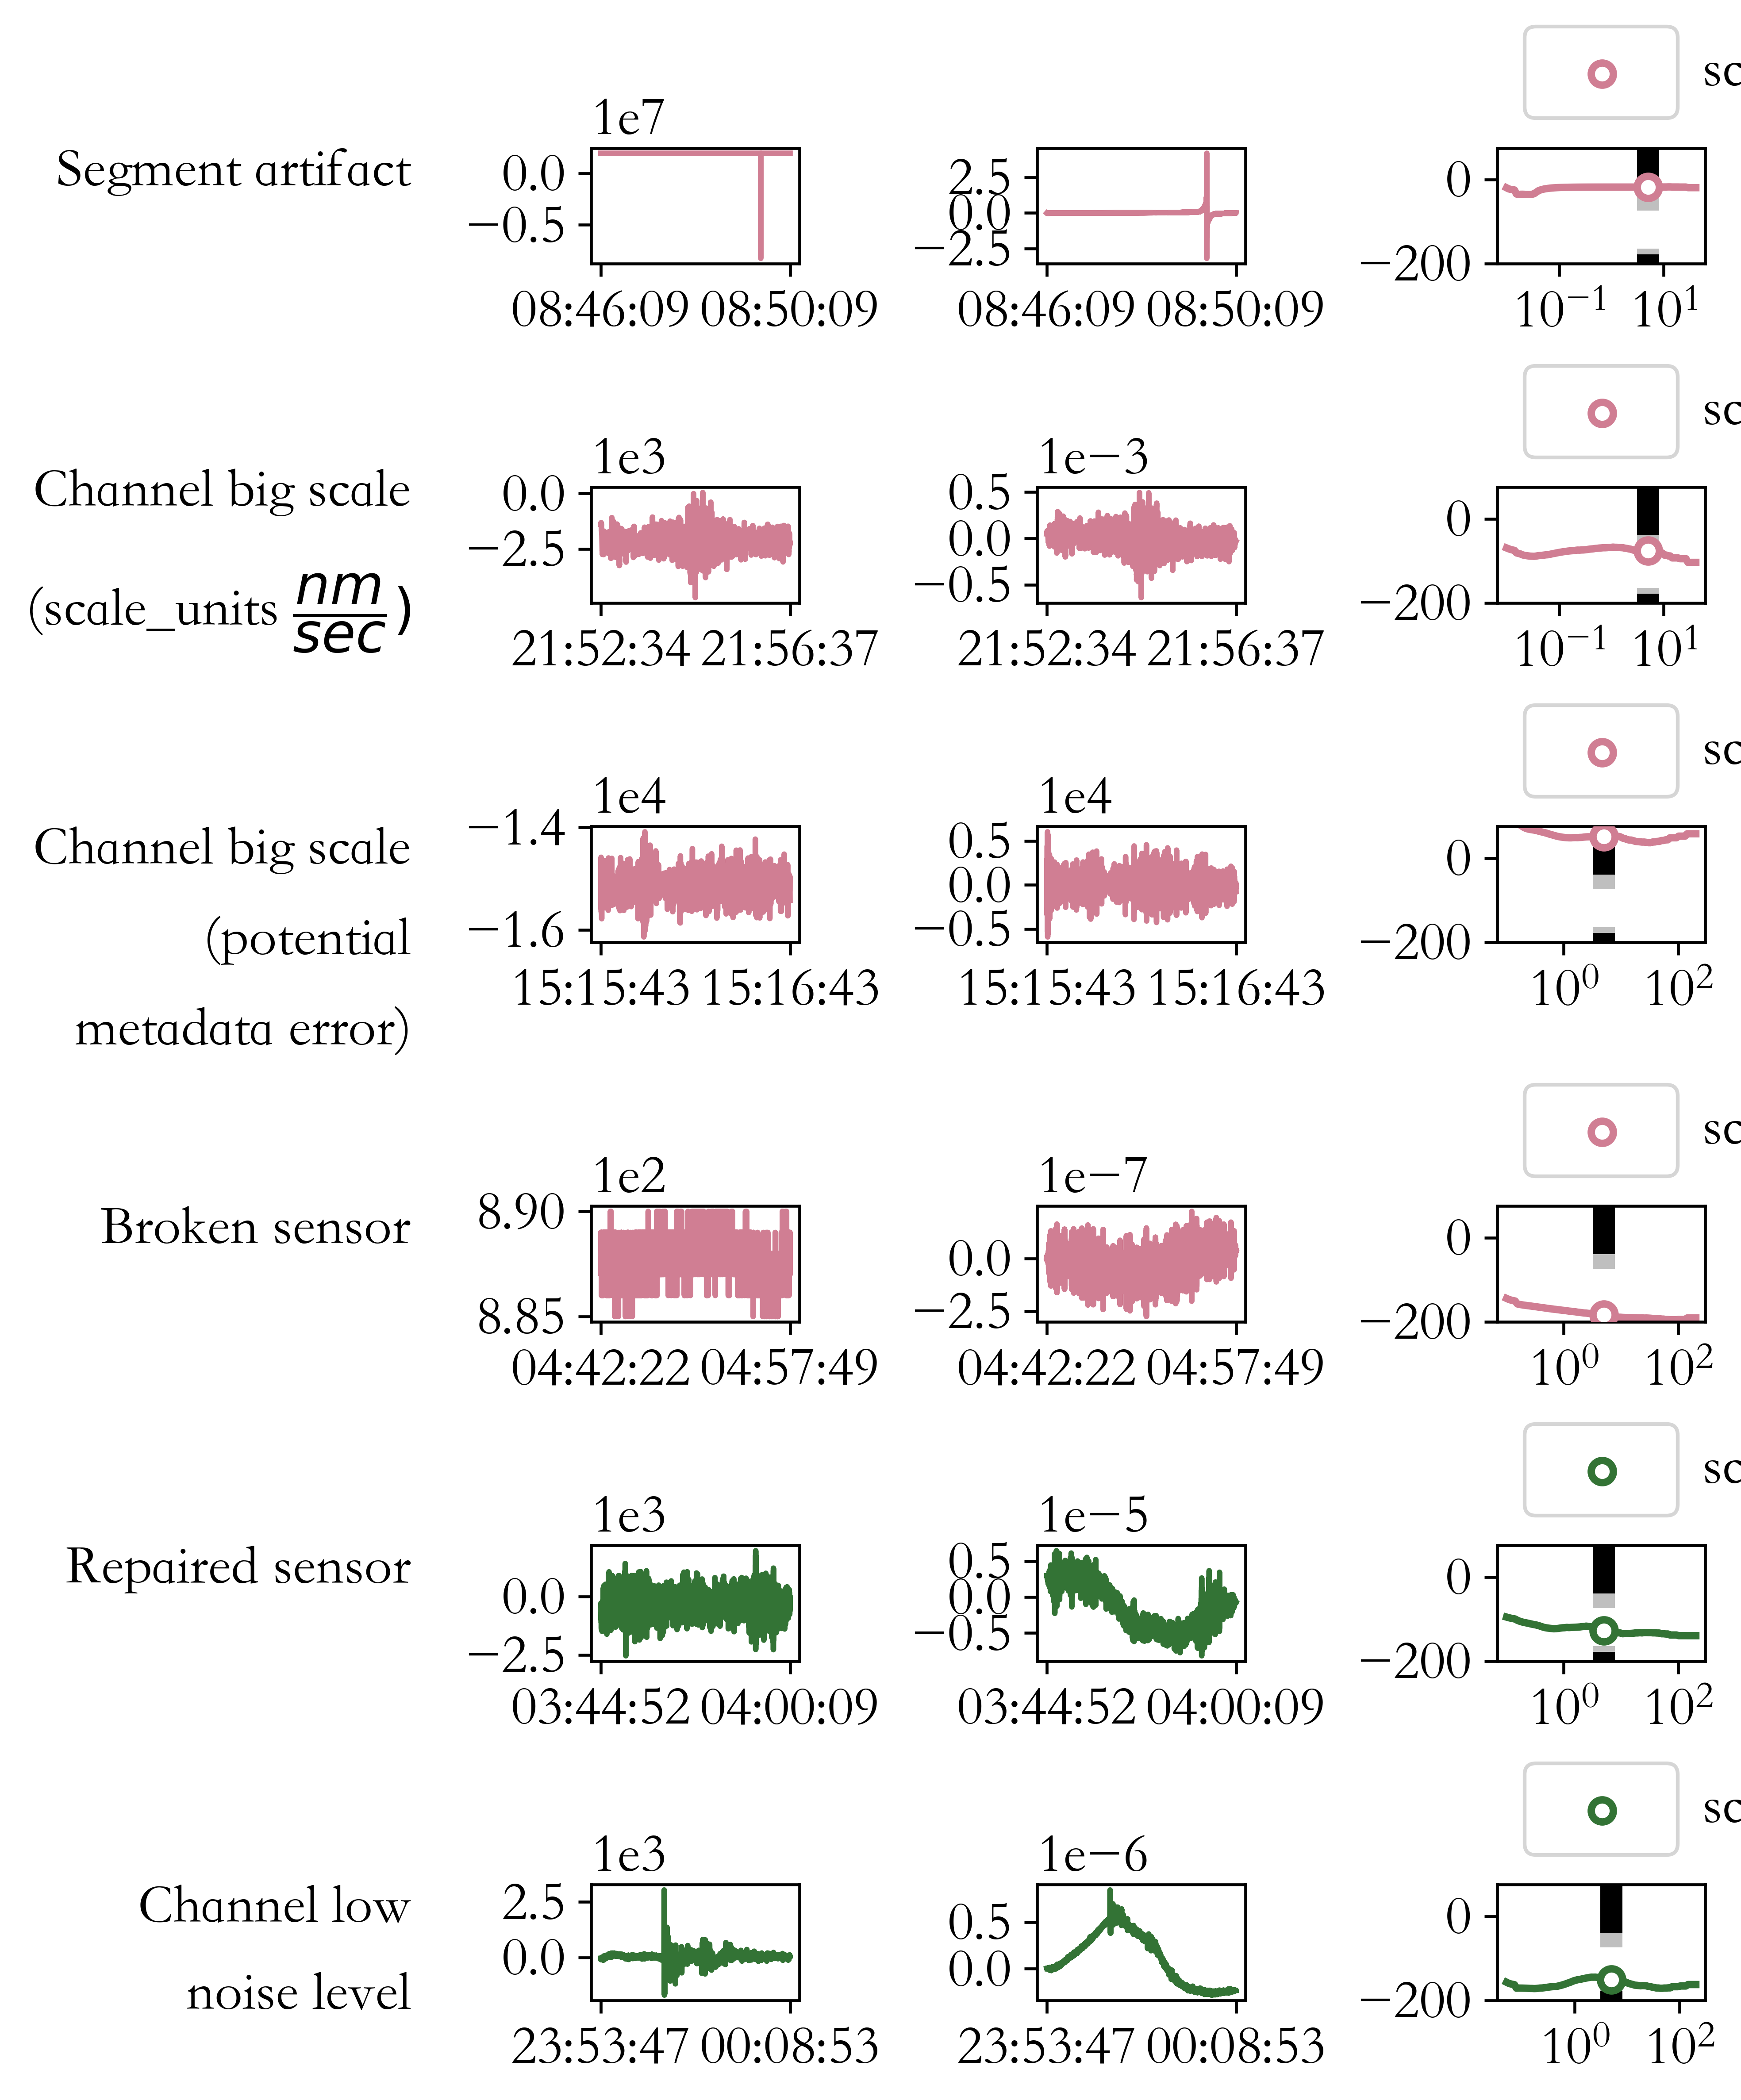

In [10]:
printhtml('<h3>Plotting some segments and their predicted score in details</h3>')

nest = 100
maxs = 1024  # 2048
setname = TESTSETNAME_U  # TESTSETNAME_12

# low and high ranges (in dB) of "undecided zone"
lpsd = [-152, -138]
hpsd = [-100, -66]
# ranges = [-152, -138], [-100, -66]

printhtml('<h4>Classifier used:</h4>')
eval_df3 = eval_df2[(eval_df2.n_estimators == nest) & (eval_df2.max_samples == maxs)]
display(eval_df3)
clf = load_clf(dirname(eval_df3.relative_filepath.iloc[0]) + '.sklmodel')
display(clf)
pred_df = read_pred_df(join(dirname(eval_df3.relative_filepath.iloc[0]), setname), columns=None)

def ppsd_2(segment, inventory):
    periods, amplitudes_db = ppsd(seg.stream()[0], seg.inventory())
    _, amplitude_db_5 = ppsd(seg.stream()[0], seg.inventory(), 5)
    return periods, amplitudes_db, amplitude_db_5


def plot_trace(axs, trace, inventory=None, **kwargs):
    from obspy import UTCDateTime
    # time0, dt = trace.stats.starttime, trace.stats.delta
    # times = [(time0 + dt*i).datetime for i in range(len(trace))]
    # trace = trace.trim(None, trace.stats.starttime+60)
    if inventory is not None:
        trace = trace.copy().remove_response(inventory)
    axs.plot(trace, **kwargs)
    axs.set_xticks([0, len(trace)-1])
    stime = UTCDateTime(int(np.round(float(trace.stats.starttime))))
    etime = UTCDateTime(int(np.round(float(trace.stats.endtime))))
    # would be nice if the first tick displayed the date also, something as: stime.isoformat().replace('T', ' ')
    # but then labels take too much room. So:
    ticklabel1 = stime.isoformat()[stime.isoformat().find('T')+1:]
    ticklabel2 = etime.isoformat()[etime.isoformat().find('T')+1:]
    axs.set_xticklabels([ticklabel1, ticklabel2])
    axs.ticklabel_format(axis='y', style='sci', scilimits=(-0,0))
    # axs.grid()


PSD_YLIM = (-200, 75)


def plot_psd(axs, trace, inventory, **kwargs):
    periods, amplitudes_db, amplitude_db_5 = ppsd_2(trace, inventory)
    kwargs.setdefault('linewidth', 2)
    axs.semilogx(periods, amplitudes_db, **kwargs)
    
#     areacolor = [0.85, 0.85, 0.85]  # outlier zone in dark gray:
#     axs.set_facecolor(areacolor)
#     areacolor = [0.925, 0.925, 0.925]
#     axs.axhspan(lpsd[0], hpsd[1], alpha=1, zorder=-10, color=areacolor, fill=True)
#     areacolor = [1, 1, 1]
#     axs.axhspan(lpsd[1], hpsd[0], alpha=1, zorder=-10, color=areacolor, fill=True)
    
    
    axs.axvline(5, color=[0., 0., 0.], linewidth=6)
    axs.plot([5, 5], [lpsd[0], hpsd[1]], marker='None', color=[0.75, 0.75, 0.75], linewidth=6)
    axs.plot([5, 5], [lpsd[1], hpsd[0]], marker='None', color=[1, 1, 1], linewidth=6)
    
#     areacolor = [0.85, 0.85, 0.85]  # outlier zone in dark gray:
#     axs.set_facecolor(areacolor)
#     areacolor = [0.925, 0.925, 0.925]
#     axs.axhspan(lpsd[0], hpsd[1], alpha=1, zorder=-10, color=areacolor, fill=True)
#     areacolor = [1, 1, 1]
#     axs.axhspan(lpsd[1], hpsd[0], alpha=1, zorder=-10, color=areacolor, fill=True)
    
    
    # areacolor = [0.8, 0.8, 0.8]
    # axs.axhline(lpsd[1], linestyle='--', zorder=-5, color=areacolor)
    # axs.axhline(hpsd[0], linestyle='--', zorder=-5, color=areacolor)
    
    clf_score = -clf.score_samples([[amplitude_db_5]])
    color = kwargs.get('color', 'black')
    axs.scatter(5, amplitude_db_5, marker='o', label='score=%.2f' % clf_score,
                color='white', edgecolor=color, linewidth=2, zorder=100)
    axs.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', mode='expand')
    axs.set_ylim(*PSD_YLIM)
    #axs.grid()


def plotall(segment, row_idx, caption, trace=None, inv=None):
    '''plots a row of plots'''
    if trace is None:
        trace = segment.stream()[0]
    if inv is None:
        inv = segment.inventory()
    # show the already computed scores for a double check:
    seg_pred_df = pred_df[(pred_df['Segment.db.id'] == seg.id) & (pred_df.dataset_id == dataset_id)]
    print()
    print('Segment to plot:')
    display(seg_pred_df)
    # get all channel segments and print median score:
    scores = pred_df[(pred_df.station_id == seg.channel.station_id) & (pred_df.dataset_id == dataset_id) &
                     (pred_df.location_code == seg.channel.location) & (pred_df.channel_code == seg.channel.channel)].predicted_anomaly_score
    print('%d segments of same channel found, median score: %.2f' % (len(scores), scores.median()))
    print()
    # assert labelling is correct (just a check):
    outliers_count = seg_pred_df.outlier.sum() 
    assert outliers_count in (0, len(seg_pred_df))
    kwargs = {'color': colors[bool(outliers_count)]}
    # plot stuff:
    axs0 = fig.add_subplot(gsp[row_idx, 0])
    axs0.text(0.5, 1, caption, ha='right', va='top', rotation=0, linespacing=2,
              fontsize=plt.rcParams['axes.titlesize'])  # , family='monospace') 
    axs0.set_axis_off()
    axs1 = fig.add_subplot(gsp[row_idx, 1])
    plot_trace(axs1, trace, **kwargs)
    axs2 = fig.add_subplot(gsp[row_idx, 2])
    plot_trace(axs2, trace, inv, **kwargs)
    axs3 = fig.add_subplot(gsp[row_idx, 3])
    plot_psd(axs3, trace, inv, **kwargs)
    # if row_idx == 0:
    #    axs1.set_title('Trace')
    #    axs2.set_title('Trace (resp. removed)')
    #    axs3.set_title('PSD')
    
    allaxes = axs1, axs2, axs3
    # don't know why, but the gird appears on the LASt psd (??!)
    # turn grid off for all axes (set to True to turn it on):
    for _ in allaxes:
        _.grid(False, which='major', axis='both', linewidth=0)
    return allaxes


with plotparams(hratio=1.1):

    fig = plt.figure(constrained_layout=True)
    gsp = fig.add_gridspec(6, 4, width_ratios=[1, 10, 10, 10])

    colors = get_colors(2, 0.35, 0.6)  # [::-1]


    # filter for the db query (common to all):
    flt = (Segment.has_data) & (Segment.maxgap_numsamples.between(-0.499, 0.499))

    psd_axes = []
    rowindex = -1

    # good station, segment is an outlier
    rowindex += 1
    dataset_id = 1
    with dbsession(dataset_id) as sess:
        # sta_ids = [_[0] for _ in sess.query(Station.id).filter((Station.netsta_code == 'IS.GEM' ) & Station.has_inventory)]
        # seg_ids = pred_df[pred_df.station_id.isin(sta_ids)]
        seg_id = 21202165  # int(seg_ids.iloc[0]['Segment.db.id'])
        seg = sess.query(Segment).filter((Segment.id == seg_id) & flt).limit(1).one()
        _ = plotall(seg, rowindex, 'Segment artifact')
        psd_axes.append(_[-1])

    # Scale_units = nm/sec
    # they specify a good scale_units, but obspy's documentation asserts that they
    # assume units in m/sec (FIXME: citation?!!)
    rowindex += 1
    dataset_id = 1
    with dbsession(dataset_id) as sess:
        sta_ids = [_[0] for _ in sess.query(Station.id).filter((Station.network == 'SL' ) & Station.has_inventory)]
        seg_ids = pred_df[pred_df.station_id.isin(sta_ids)]
        seg_id = int(seg_ids.iloc[0]['Segment.db.id'])
        seg = sess.query(Segment).filter((Segment.id == seg_id) & flt).limit(1).one()
        _ = plotall(seg, rowindex, 'Channel big scale\n(scale_units $\\dfrac{nm}{sec})$')
        psd_axes.append(_[-1])

    # Scale is big,  but scale units is ok, most likely metadata error.
    # We cannot say which is the cause, but the anomaly detector is good
    # (we suspect some mistake in the inventory)
    rowindex += 1
    dataset_id = 2
    with dbsession(dataset_id) as sess:
        sta_ids = [_[0] for _ in sess.query(Station.id).filter((Station.network == 'SJ' ) & Station.has_inventory)]
        seg_ids = pred_df[pred_df.station_id.isin(sta_ids)]
        seg_id = int(seg_ids.iloc[0]['Segment.db.id'])
        seg = sess.query(Segment).filter((Segment.id == seg_id) & flt).limit(1).one()
        # in this case, display only noise otherwise it seems we
        # can classify only signals:
        tra = seg.stream()[0].copy().trim(None, seg.stream()[0].stats.starttime + 60)
        _ = plotall(seg, rowindex, 'Channel big scale\n(potential\nmetadata error)', trace=tra)  
        psd_axes.append(_[-1])


    # # Metadata stage gain error
    # from obspy import read_inventory
    # inv = read_inventory(join(dirname(dirname(os.get_cwd())), 'stream2segment', 'inventories',
    #                           'CH.GRIMS.2015-10-30T10:50:00.xml'))
    # rowindex += 1
    # dataset_id = 1
    # with dbsession(dataset_id) as sess:
    #     sta_ids = [_[0] for _ in sess.query(Station.id).filter((Station.netsta_code == 'CH.GRIMS' ) & Station.has_inventory)]
    #     seg_ids = pred_df[pred_df.station_id.isin(sta_ids)]
    #     seg_ids = seg_ids['Segment.db.id'].tolist()
    #     seg = sess.query(Segment).join(Segment.event).filter(Segment.id.in_(seg_ids) & (Event.time < datetime(2016, 1, 1)) & flt).limit(1).one()
    #     _ = plotall(seg, rowindex, 'Metadata\nstage gain\nerror', inv=inv)
    #     psd_axes.append(_[-1])


    # # Metadata stage gain error
    # rowindex += 1
    # dataset_id = 1
    # with dbsession(dataset_id) as sess:
    #     sta_ids = [_[0] for _ in sess.query(Station.id).filter((Station.netsta_code == 'CH.GRIMS' ) & Station.has_inventory)]
    #     seg_ids = pred_df[pred_df.station_id.isin(sta_ids)]
    #     seg_ids = seg_ids['Segment.db.id'].tolist()
    #     seg = sess.query(Segment).join(Segment.event).filter(Segment.id.in_(seg_ids) & (Event.time > datetime(2018, 1, 1)) & flt).limit(1).one()
    #     _ = plotall(seg, rowindex, 'Stage gain\nerror fixed')
    #     psd_axes.append(_[-1])


    # Broken sensor:
    rowindex += 1
    dataset_id = 2
    with dbsession(dataset_id) as sess:
        sta_ids = [_[0] for _ in sess.query(Station.id).filter((Station.netsta_code == 'NU.MGAN' ) & Station.has_inventory)]
        seg_ids = pred_df[pred_df.station_id.isin(sta_ids)]
        seg_ids = seg_ids['Segment.db.id'].tolist()
        seg = sess.query(Segment).join(Segment.event).filter(Segment.id.in_(seg_ids) & (Event.time < datetime(2019, 1, 1)) & flt).limit(1).one()
        _ = plotall(seg, rowindex, 'Broken sensor')
        psd_axes.append(_[-1])

    # Broken sensor repaired (same channel as above):
    rowindex += 1
    dataset_id = 2
    with dbsession(dataset_id) as sess:
        sta_ids = [_[0] for _ in sess.query(Station.id).filter((Station.netsta_code == 'NU.MGAN' ) & Station.has_inventory)]
        seg_ids = pred_df[pred_df.station_id.isin(sta_ids)]
        seg_ids = seg_ids['Segment.db.id'].tolist()
        seg = sess.query(Segment).join(Segment.event).filter(Segment.id.in_(seg_ids) & (Event.time > datetime(2019, 6, 1)) & flt).limit(1).one()
        _ = plotall(seg, rowindex, 'Repaired sensor')
        psd_axes.append(_[-1])


    # Low channel noise
    rowindex += 1
    dataset_id = 2
    with dbsession(dataset_id) as sess:
        sta_ids = [_[0] for _ in sess.query(Station.id).filter((Station.netsta_code == 'IS.GEM' ) & Station.has_inventory)]
        seg_ids = pred_df[pred_df.station_id.isin(sta_ids)]
        seg_id = int(seg_ids.iloc[0]['Segment.db.id'])
        seg = sess.query(Segment).filter((Segment.id == seg_id) & flt).limit(1).one()
        _ = plotall(seg, rowindex, 'Channel low\nnoise level')
        psd_axes.append(_[-1])

    # for _ in psd_axes:
    #    _.set_ylim(-200, 50)
    # samey(psd_axes)

    savefig(fig, 'interesting_segments_detailed_scores')
    plt.grid()
    plt.show()


In [11]:
# robustness wrt gain change in the response
# create an array of 100 "good" psd periods (see figure above)
psds = np.random.uniform(lpsd[1],hpsd[0], [1000,1]) # A 2x3 array
scores = -clf.score_samples(psds)
cc = (scores <= 0.5).sum() / float(len(scores))
printhtml(f'<h4>CC instances (<=0.5): {cc:.2f}</h4>')
data = {'Resp. multiplication factor': [], 'Correctly classified ratio': []}
for factor in [0.0005, 0.001, 0.01, 0.1, 1, 10, 100, 150, 1000]:
    # factor = 10.0 ** N
    if factor == 1:
        cc_ = cc
    else:
        psds_ = np.copy(psds) - 10 * np.log10(factor ** 2)
        scores_ = -clf.score_samples(psds_)
        cc_ = (scores_ > 0.75).sum() / float(len(scores_))
    data['Resp. multiplication factor'].append(factor)
    data['Correctly classified ratio'].append(cc_)

display(pd.DataFrame(data))

CC instances (<=0.5): 1.00

,Resp. multiplication factor,Correctly classified ratio
0,0.0005,0.680
1,0.0010,0.518
2,0.0100,0.000
3,0.1000,0.000
4,1.0000,1.000
5,10.0000,0.215
6,100.0000,0.744
7,150.0000,0.834
8,1000.0000,1.000
